In [11]:
import import_ipynb
import random
%matplotlib inline
import matplotlib.pyplot as plt
import statistics
import warnings
import numpy as np
import copy
import scipy.stats
import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from IPython.core.debugger import set_trace
import os.path
warnings.filterwarnings("ignore")


In [2]:
from KEM_General import Super_General_Model
from KEM_General import General_Model_MultiCity

importing Jupyter notebook from KEM_General.ipynb


In [12]:
# General Simulation Class

class Super_General_Model(object):
    
    def __init__(self,N=500,mu=50.):
        self.debug = False
        self.N = N
        self.populate(N,mu)
        self.time = 0
        self.mu = mu
    
    def populate(self):
        """
        initialize population with distribution of income and parameters (e.g. lambda) applied to agents
        within structure (e.g. grid)
        
        """
        pass
    
    
    class agent:
        def __init__(self,income=0.):
            self.income = income      
        
    
    def choose_agents(self):
        """
        Input: None
        
        Output: A pair of agents who are going to interact. This becomes the input to interact
        """
        pass
    
    def interact(self,agents):
        """
        Input: Return value of choose_agents, the agents to interact
        
        Output: list of agent incomes
        
        Changes selected agent incomes/wealths according to KEM interaction mechanism and return new distribution
        """
        pass

    
    def get_income_dist(self):
        """
        returns the income distribution as a list of incomes
        """
        pass
   

#     def simulate(self,debug=False):
#         '''
#         Simulate takes a certain initial population, and makes them interact.

#         Inputs:
#             population. list. Initial income distribution
#             # steps. int. Time steps to execute the simulation
#             transaction. function. function that describes the dynamic of the transaction.
#             interaction. function. function that describes the dynamic of the interaction.

#         Outputs:
#             population after steps number of steps. 

#         '''

#         while(true):
#             to_interact = self.choose_agents()
#             new_distribution = self.interact(to_interact)
            
#             ### Debugging code
#             if self.debug:
#                 prev = np.array(self.get_income_dist())
#                 print("\n\n\nprev:",prev)
#                 print("sum:",sum(self.get_income_dist()))
#                 #diff = (np.array(new_distribution) - prev)/prev
#                 diff = (np.array(new_distribution) - prev)
#                 nz = np.nonzero(diff)
#                 lams = np.array([a.lambda_ for a in self.population])
#                 for dif,lam in zip(diff[nz],lams[nz]):
#                     if dif < 0:
#                         if dif > (1-lam):
#                             print("I THINK THAT'S WRONG")
#                 print("diff",diff)
#                 population = self.get_income_dist()
#                 print("new:",population)
#                 print("sum:",sum(population))
                
#             yield new_distribution

    def simulate(self,steps=100):
        '''
        Simulate takes a certain initial population, and makes them interact.

        Inputs:
            population. list. Initial income distribution
            # steps. int. Time steps to execute the simulation
            transaction. function. function that describes the dynamic of the transaction.
            interaction. function. function that describes the dynamic of the interaction.

        Outputs:
            population after steps number of steps. 

        '''

#         for n in range(steps):
        #print("in simulate, n = ",n)
        to_interact = self.choose_agents()
        new_distribution = self.interact(to_interact)

        ### Debugging code
        if self.debug:
            prev = np.array(self.get_income_dist())
            print("\n\n\nprev:",prev)
            print("sum:",sum(self.get_income_dist()))
            #diff = (np.array(new_distribution) - prev)/prev
            diff = (np.array(new_distribution) - prev)
            nz = np.nonzero(diff)
            lams = np.array([a.lambda_ for a in self.population])
            for dif,lam in zip(diff[nz],lams[nz]):
                if dif < 0:
                    if dif > (1-lam):
                        print("I THINK THAT'S WRONG")
            print("diff",diff)
            population = self.get_income_dist()
            print("new:",population)
            print("sum:",sum(population))

        return new_distribution

                
          
    def reset(self):
        self.populate(self.N,self.mu)
        
        
    def calc_dmdt(self,prev_dist,new_dist):
        """
        returns a 3-element np array of absolute value difference in 3rd moment between two distributions 
        """
        mdifs = []
        for n in [3]:#[2,3,4]:
            mold = scipy.stats.moment(prev_dist,moment=n)
            mnew = scipy.stats.moment(new_dist,moment=n)
            mdif = np.abs((mold - mnew)/mnew)
            mdifs.append(mdif)
        return np.array(mdifs)         
  
    ####################### ANALYSIS ##################################
    
    def kde_dist(self,title=None):
        """
        creates and displays a probability distribution function of the model 
        incomes, generated from a Gaussian Kernel Density Estimation
        """

        def thin_silverman(kde_inst):
            n = kde_inst.n
            d = kde_inst.d
            silverman = (n * (d + 2) / 4.)**(-1. / (d + 4))
            scale = 1.
            return silverman*scale

        incomes = np.array(self.get_income_dist())
        # NOTE: Wide Silverman is bad because there's many more agents here - extrapolation really not needed even
        kde = scipy.stats.gaussian_kde(self.get_income_dist(),bw_method=thin_silverman)
        x = np.linspace(0,1.2*max(incomes),100)





        datx,daty = x,kde.pdf(x)

        plt.figure()
        plt.plot(datx,daty,c='red')

        if not title:
            title = "KDE-generated PDF of income/wealth"
        
        plt.title(title)
        plt.xlabel("income")
        plt.ylabel("probability")
        plt.show()
        plt.close()
    



    
    def gini(self,p):

        "Gini coefficient (equation from wikipedia)"

        y = sorted(p)
        n = len(p)

        numer = 2 * sum((i+1) * y[i] for i in range(n))
        denom = n * sum(y)

        return (numer / denom) - (n + 1) / n


    def hist(self, population, label='Dist', **kwargs):
        label = label + ': G=' + str(round(self.gini(population), 2))

        h = plt.hist(list(population), alpha = 0.4, bins = 200, label= label, **kwargs)

        plt.xlabel('Wealth')
        plt.ylabel('Count')
        plt.grid(True)

        plt.legend()


    #NOTE: Eli, please update this
    def show(self, percentiles=(1, 10, 50, 90, 99), **kwargs):

        '''
        print statistics and display a plot and histogram.

        '''

        if self.time == 0:
            print("ERROR: HASN'T RUN YET!")
            return

        # Statistics

        print('   t    Gini stdev' + (' {:3d}%' * len(percentiles)).format(*percentiles))


        fmt = '{:7,d} {:.2f} {:5.1f}' + ' {:4.0f}' * len(percentiles)
  
        initsum = self.N*self.mu
        t = 0
        for pop in self.results:
            t += 1
            pop = sorted(pop)
            if t % (4 * self.N) == 0:
                data = [self.percent(pct, pop) for pct in percentiles]
                print(fmt.format(t, self.gini(pop), statistics.stdev(pop), *data))


    #     #plot individual trajectory
    #     plt.hold(True)
    #     plt.xlabel('Time')
    #     plt.ylabel('Wealth')
    #     plt.grid(True)
    #     plt.plot(times, lists)

    #     plt.show()





        # Plot

    #     plt.xlabel('Time')
    #     plt.ylabel('Wealth')
    #     plt.grid(True)

    #     for pct in percentiles:
    #         #TODO: this should average over all people in different percentiles, or make a separate thing to do that
    #         line = [percent(pct, pop) for pop in results]
    #         plt.plot(times, line)

    #     plt.show()


        # Histogram
        start = self.results[0]
        pop = self.results[-1]
        #R = (min(pop), max(pop))
        R = (min(pop+start), max(pop+start))
        self.hist(start, 'Initial', range=R)
        self.hist(pop, 'Final', range=R)
        plt.show()
        plt.close()
        
        

    def normalize(self,numbers, mu):

        '''
        Positive values, and scale them so they have mean mu.

        '''

        numbers = [max(0, n) for n in numbers]

        factor = len(numbers) * mu / sum(numbers)

        return [x * factor for x in numbers]

    def samples(self,distribution, *args, n = None, mu = None):
        '''
        Sample from the distribution n times,
        then normalize results.

        '''
        if not n:
            n = self.N
        if not mu:
            mu = self.mu

        numbers = [distribution(*args) for _ in range(n)]
        return self.normalize(numbers, mu)


    def percent(self,pct, items):
        '''
        The item that is pct percent through the sorted list of items.

        '''
        return items[min(len(items)-1, len(items) * pct // 100)]



    def animate_distributions(self,times=[0,1],n_frames=100,average=True):
        """
        
        Inputs:
            times. list of ints (length = 2). starting and ending times to run
            n_frames. int. number of frames in animation
            average. bool. If true, will average distributions over all distributions between each timeframe.
                Number of averaged time_steps = round(times[1]/n_frames))
        
        Output: 
            animation object
        
        animates distributions over time in simulation
        
        """

        pop_series = self.results
        run_times = []

        duration = times[1]-times[0]
        tstep = round(float(duration)/n_frames)

        max_t = self.time

        fig = plt.figure()
        def animate(i):
            #label = label + ': G=' + str(round(gini(population), 2))
            plt.cla()
            time = times[0]+i*tstep
            if time < max_t:
                # take average 
                if average:
                    plotvals = np.average(pop_series[time:(time+tstep)],axis=0)
                else:
                    plotvals = pop_series[time]
                plt.hist(plotvals, alpha = 0.4, bins = 30, label=str(time))
                plt.legend()
                plt.xlabel('Wealth')
                plt.ylabel('Count')
                plt.grid(True)

        anim = FuncAnimation(fig, animate, #init_func=init,
                                       frames=n_frames)#), interval=20)#, blit=True)
        HTML(anim.to_jshtml())
        return anim



    def test_stability(self,n_steps=50,end_time=1000):
        
        """
        Inputs:
            n_steps: number of steps over which to analyze stability of distribution
            end_time: last time to analyze.
            
        produces histograms of standard deviations of each agent's wealth over last n_steps steps up until time end_time
        
        """
        
        pop_series = np.array(self.results)
        t_series = pop_series[(end_time-n_steps):end_time]
        stds = []
        mus = []
        for agent_n in range(len(t_series[0])):
            agent_series = t_series[:,agent_n]
            std = np.std(agent_series)
            stds.append(std)
            mus.append(np.mean(agent_series))
        plt.figure()
        plt.hist(stds)
        xlbl = "standard deviations of wealth (unit=absolute wealth); t=["+str(end_time-n_steps)+","+str(end_time)+"]"
        plt.xlabel(xlbl)
        plt.show()


        stds,mus = np.array(stds),np.array(mus)
        plt.figure()
        plt.hist((stds/mus))
        xlbl = "standard deviations of wealth (unit=percent wealth); t=["+str(end_time-n_steps)+","+str(end_time)+"]"
        plt.xlabel(xlbl)
        plt.show()
        
        plt.close()
        
        


In [13]:
# For population size analysis
# 
# class General_Model_MultiCity(object):
# For population size analysis

class General_Model_MultiCity(object):
    
    def __init__(self,obj):
        """
        Inputs:
            obj. Super_General_Model. The class of the model type you want to analyze. 
                Example: General_Model_MultiCity.run_many_pops(KEM_Grid) (note that you should not instantiate the KEM_Grid class)        
        """
        self.obj = obj
        
    def run_many_pops(self,mu=50000.,avg=False,avg_step=3,pops=None,add=False):
        """
        Inputs:
            mu. float. the average wealth of agents
            
            -- OBSELETE IF ONLY STORING FINAL TIME-STEP FOR EFFICIENCY
            avg. boolean. whether or not to average a set of the final timesteps
            avg_step. float. fraction (between 0 and 1) of a full time-step to count in the averaging
            -- OBSELETE IF ONLY STORING FINAL TIME-STEP FOR EFFICIENCY
            
            pops. list. optional input list of population sizes to run on
            add. boolean. If true, append results to existing results. If false, replace existing results
        
        Output: None
        
        Runs model simulations of varying population sizes. 
        Currently distributes city population sizes according to a zipf's law distribution
    
        """
        if not add:
            self.hists = []
        # generated by zipf's law distribution
#         self.popsizes = np.unique(np.random.zipf(1.4,300)*10)[8:30:3]
        if pops:
            
            if pops == "Empirical":
                self.popsizes = np.load("empirical-model_pops.npy")
                pops_to_run = self.popsizes
            else:
                if add:
                    self.popsizes += pops
                    pops_to_run = pops
                else:
                    self.popsizes = pops
                    pops_to_run = pops
        else:
            self.popsizes = [66000,110000]#[200,1000,5000,10000,33000,
            pops_to_run = self.popsizes
        print("popsizes:",self.popsizes)
        sims = {}
        
        max_pop = max(pops_to_run)
        min_pop = min(pops_to_run)
        for popsize in pops_to_run:
            popsize = int(popsize)
            nsteps = 100
#             #make runtime proportional to citysize
#             nsteps_max = 130
#             n_steps_min = 100
#             y0 = nsteps_max/(max_pop**0.12)
#             nsteps = int(y0*popsize**0.12)
#             nsteps = int(n_steps_min + (nsteps_max - n_steps_min)*((popsize-min_pop)/(max_pop-min_pop)))
            print("nsteps:",nsteps)
            
            # instantiate model class
            sims[popsize] = self.obj(N=popsize,mu=mu,max_pop = max_pop)
            print("\n NEW SIM\npopulation = ",popsize)
            results = sims[popsize].run(nsteps=nsteps,n_keep=avg_step)
            # append distribution from last time step
            if avg:
                # average over avg_step percent of time-steps required for every agent to (on average) interact once
                self.hists.append(np.average(np.array(results[-avg_step:]),axis=0))
            else:
                self.hists.append(results[-1])

    def save_results(self,name="UNNAMED_RESULTS"):
        """
        Saves a numpy file of the model output, using the format specified in ModelComparison.ipynb
        
        Inputs: name, name of file
        
        Output: None
        """
        
        if name == "UNNAMED_RESULTS":
            print("WARNING! Please give a proper name for results!")
        # 
        savedata = np.array(list(zip(np.array(self.popsizes),np.array(self.hists))))
        fname = name + ".npy"
        np.save(fname,savedata)


# class MetaModel(General_Model_MultiCity):
    
        
#     def run_many_pops(self,mu=50.,avg=False,avg_step=.1,pops=None,add=False):
#         """
#         Inputs:
#             mu. float. the average wealth of agents
            
#             -- OBSELETE IF ONLY STORING FINAL TIME-STEP FOR EFFICIENCY
#             avg. boolean. whether or not to average a set of the final timesteps
#             avg_step. float. fraction (between 0 and 1) of a full time-step to count in the averaging
#             -- OBSELETE IF ONLY STORING FINAL TIME-STEP FOR EFFICIENCY
            
#             pops. list or string. optional input list of population sizes to run on
#                         if pops is "Empirical," will create a distribution similar to the empirical data
#             add. boolean. If true, append results to existing results. If false, replace existing results
        
#         Output: None
        
#         Runs model simulations of varying population sizes. 
#         Currently distributes city population sizes according to a zipf's law distribution
    
#         """
#         if not add:
#             self.hists = []
#         # generated by zipf's law distribution
# #         self.popsizes = np.unique(np.random.zipf(1.4,300)*10)[8:30:3]
#         #self.popsizes = [60,90,120,150,180,210,280,340,390,460,520,580,730,840,910,1160,1330,1610, 1820, 2910, 3970, 5130, 7430]
#         if pops:
            
#             if pops == "Empirical":
#                 self.popsizes = np.load("empirical-model_pops.npy")
#                 pops_to_run = self.popsizes
#             else:
#                 if add:
#                     self.popsizes += pops
#                     pops_to_run = pops
#                 else:
#                     self.popsizes = pops
#                     pops_to_run = pops
#         else:
#             self.popsizes = [66000,110000]#[200,1000,5000,10000,33000,
#             pops_to_run = self.popsizes
#         print("popsizes:",self.popsizes)
#         sims = {}
#         for popsize in pops_to_run:
#             popsize = int(popsize)
#             # instantiate model class
#             sim = self.obj(N=popsize,mu=mu)
#             print("\n NEW SIM\npopulation = ",popsize)
#             #TODO: set to auto once convergence works properly
#             sim.normalize(silence=True)
#             results = sim.run(convergence="manual")
#             sim.normalize(silence=True)
#             # append distribution from last time step
#             if avg:
#                 # average over avg_step percent of time-steps required for every agent to (on average) interact once
#                 d_steps = int(avg_step*sims[popsize].N/2)
#                 self.hists.append(np.average(np.array(results[-d_steps:]),axis=0))
#             else:
#                 self.hists.append(results[-1])


        


In [14]:
# Simulation with purely random interactions

class Any_Net(Super_General_Model):
    
    def __init__(self,N=500,mu=50.,network_f=None,transaction_f=None,max_pop=None):
   
        self.network_f = network_f
        self.max_pop = max_pop
        self.results = []
        self.transaction_f = transaction_f
        self.debug = False
        self.N = N
#         print("running populate")
        self.populate(n=N,mu=mu,max_pop=max_pop)
        print("finished populate")
        self.time = 0
        self.mu = mu
#         Super_General_Model.__init__(self,N=N,mu=mu)
    
    ### NOTE (from NetworkX): "You should not change the node object if the hash depends on its contents."

    
    class Agent:
        def __init__(self,income=0.,lambda_=0.):
            self.income = income  
            self.lambda_ = lambda_
            

    #initial values (population size & mean of the income distribution)
    def populate(self,n=500,mu=50.,max_pop=None):
        """
        initialize population with distribution of income and parameters (e.g. lambda) applied to agents
        within structure (e.g. grid)
        
        """
        self.N=n
        self.time = 0
        incomes = [np.random.uniform(0, mu*2.) for actor in range(n)]
        
        # lambda values
        min_lambda = 0.2
        max_lambda = 0.9
        lambda_ = np.random.power(0.3,n)
        # rescale lambda
        lambda_ *= max_lambda - min_lambda
        lambda_ += min_lambda
        
        
        maxlambda = 0.97
        i = 0
        # make sure no lambdas are above 1
        for l in lambda_:
            if l >=maxlambda:
                lambda_[i] = np.random.power(.3)
                if lambda_[i]>=maxlambda:
                    lambda_[i] = 0.9
            i+=1
                
#         print("building network")
        self.network = self.network_f(n,max_pop=max_pop)#nx.gnp_random_graph(n, 0.001, directed=False)
#         print("finished building network")
        #TODO: Merge this (from Eli)
        for inc,lam,node in zip(incomes,lambda_,self.network.nodes):
            
#             self.network.nodes[node]['wealth'] = np.random.uniform(0, 100)
#             self.network.nodes[node]['eta'] = np.random.power(0.3)
#             self.network.nodes[node]['income'] = np.random.uniform(0, 100)
#             self.network.nodes[node]['return'] = 0.03
        
            self.network.nodes[node]['wealth'] = np.random.uniform(0, 100)
            self.network.nodes[node]['lambda'] = lam
            self.network.nodes[node]['income'] = inc
#             self.network.nodes[node]['return'] = 0.03

        #stationary adjacency matrix
        self.n_neighbors = []
        self.n_neighbors_raw = []
        for _ in list(self.network.nodes):
            nn = len(list(self.network.neighbors(_)))
            if nn != 0:
                self.n_neighbors.append(1/nn)
            else:
                self.n_neighbors.append(0)
            self.n_neighbors_raw.append(nn)
        
        self.n_neighbors_vec = np.array(self.n_neighbors)
        self.n_neighbors_raw_vec = np.array(self.n_neighbors_raw)
        #original adjacency matrix
        self.adj_mx = np.array(nx.adjacency_matrix(self.network, nodelist=None, weight='weight').todense())
        
        print("<k>=",np.average(np.array(self.n_neighbors_raw)))
#         print("<C>=",nx.average_clustering(self.network))
        
        #normalize the neighbors by the total, so we do not exceed to amount per person
        self.P = self.adj_mx * self.n_neighbors_vec.transpose()
#         self.network_edges = np.array(self.network.edges)
        self.n_edges = self.network.number_of_edges()
#         print("finished populating")
    
   
    def simulate(self, steps, metric='income',t_keep=1,show=False):
        '''
        This function update the whole network in a certain number of steps. 
        In each iteration the nodes are interacting with their respective neighbors, 
        according to the adjacency matrix. This updating function is based on the 
        functions described above, and in the paper.
        
        '''
        
      
        # including the initial distribution
        a = np.array(list(self.network.nodes(data = metric)))
        a= list(a[:, 1])
       
        results = []
        sorted_results = []
        times = []
        results.append(a)
        sorted_results.append(sorted(a))
        times.append(0)
        
        return_ = 0.0003
        
        
        
        for t in range(1, steps+1):
                if (t%20) == 0:
                    print("t=",t)

                new_wealth,new_income = self.transaction_f(nn_raw=self.n_neighbors_raw_vec,n=self.N,adj=self.adj_mx,network=self.network,n_neighbors_vec=self.n_neighbors_vec,P=self.P)
                
                #updating the functions
                for w,j,i in zip(new_wealth,new_income,self.network.nodes):
                    self.network.nodes[i]['income']=  j 
                    self.network.nodes[i]['wealth']=  w
                if t >= t_keep:
                    if metric == 'wealth':
                        results.append(new_wealth)
                        if show:
                            sorted_results.append(sorted(list(new_wealth)))
                    elif metric == 'income':
                        results.append(new_income)
                        if show:
                            sorted_results.append(sorted(list(new_income)))
                    else:
                        print("WARNING: SPECIFY INCOME OR WEALTH")

                    if show:
                        times.append(t)
        if show:
            return results, sorted_results, times
        else:
            return results
        
    def run(self, nsteps=100, metric="wealth",n_keep=1, **kwargs):
        '''
        Print stats, plot and histogram
        
        '''
        N = self.N #self.network_size
        
        # the time at which to begin storing results
        t_keep= nsteps + 1 - n_keep
        
        results = self.simulate(nsteps,t_keep=t_keep,metric=metric,show=False)
        return results
        
    def show(self, percentiles=(1, 10, 50, 90, 99), nsteps=100, metric="wealth", **kwargs):
        '''
        Print stats, plot and histogram
        
        '''
        N = self.N #self.network_size
        start = np.array(list(self.network.nodes(data =metric)))
        start= list(start[:, 1])
        
        
        results, sorted_results, times = self.simulate(nsteps,metric=metric,show=True)
    
#         # Statistics
#         print('   t    Gini stdev' + (' {:3d}%' * len(percentiles)).format(*percentiles))
    
#         fmt = '{:7,d} {:.2f} {:5.1f}' + ' {:4.0f}' * len(percentiles)
                
#         for (t, pop) in zip(times, sorted_results):
#             if t % (10) == 0:
#                 data = [self.percent(pct, pop) for pct in percentiles]
#                 print(fmt.format(t, self.gini(pop), statistics.stdev(pop), *data))
        
#         print('Avg. shortest path length:', nx.average_shortest_path_length(self.graph, weight=None))
        # Plot

        plt.xlabel('Time')
        plt.ylabel(metric)
        plt.grid(True)

        for pct in percentiles:
            line = [self.percent(pct, pop) for pop in sorted_results]
            plt.plot(times, line)
        
        plt.yscale('log')
        maxi= np.max(sorted_results[-1])
#         plt.axis([800, 900, 10**204, 10**235])
        plt.show()
            
            
        # Histogram
        
        pop = results[-1]
#         R = (min(pop+start), 150)
        R = (min(pop+start), max(pop+start))
#         self.hist(start, 'Initial',metric=metric, range=R)
        self.hist(pop, 'Final', metric=metric, range=R)
#         plt.xscale('log')
        plt.xlim((0,250))
        plt.show()
        plt.close() 
        
    def gini(self, p):
        '''
        Gini coefficient (equation from wikipedia)
        
        '''
    
        y = sorted(p)
        n = len(p)

        numer = 2 * sum((i+1) * y[i] for i in range(n))
        denom = n * sum(y)

        return (numer / denom) - (n + 1) / n
    
    def percent(self, pct, items):
        '''
        The item that is pct percent through the sorted list of items.

        '''
        return items[min(len(items)-1, len(items) * pct // 100)]

    def hist(self, p, label='Dist',metric='Income', **kwargs):
        '''
        Histogram function with specific characteristics. 
        '''
        
        label = label + ': G=' + str(round(self.gini(p), 2))

        h = plt.hist(list(p), alpha = 0.4, bins = 80, label= label, **kwargs)

        plt.xlabel(metric)
        plt.ylabel('Count')
        plt.grid(True)

        plt.legend()

    def get_lambda_dist(self):
        """
        returns the income distribution as a list of incomes
        """
        return [a.lambda_ for a in self.population]
    
    def get_income_dist(self):
        """
        returns the income distribution as a list of incomes
        """
        return [a.income for a in self.population]
    
    
    def interact(self,agents):
        """
        Input: Return value of choose_agents, the agents to interact
        
        Output: list of agent incomes
        
        Changes selected agent incomes/wealths according to KEM interaction mechanism and return new distribution
        """
        
#         eps = np.random.uniform()
        A,B = agents
        A.income,B.income = self.transaction_f(agents)
        return self.get_income_dist()
    
    
    def normalize(self,silence=False):
        inc_dist = self.get_income_dist()
        norm_sum = self.N*self.mu
        norm_factor = norm_sum/sum(inc_dist)
        if not silence:
            print("norm_factor = ",norm_factor)
        for agent in self.population:
            agent.income *= norm_factor
        self.results = list(np.array(self.results)*norm_factor)
    

In [15]:
#### NETWORKS ####
def randnet(n,max_pop=None): 
    return nx.fast_gnp_random_graph(n, 0.05, directed=False)

def randnet_Portugal(n,max_pop=None): 
        
    beta_k = 0.12 # FROM PORTUGAL PAPER

    max_k = 50

    y0_k = max_k/(max_pop**beta_k)
    k = int(y0_k*n**beta_k)
    
    
    p = k/(n-1.)
    
    return nx.fast_gnp_random_graph(n, 0.05, directed=False)

# def caveman_net(n):
#     num_cliques = n%50
#     clique_size = 5
#     return nx.connected_caveman_graph(num_cliques, clique_size)

def small_world(n,max_pop=None):
    # number of neighbors
    k = int(5 + n/20.)
    p = 0.09
#     return nx.connected_watts_strogatz_graph(n, k, p)
    return nx.watts_strogatz_graph(n=n, k = int(5+ n/20), p= 0.09)

def small_world_static(n,max_pop=None):
    # number of neighbors
    k = 40
    p = 0.3
#     return nx.connected_watts_strogatz_graph(n, k, p)
    return nx.watts_strogatz_graph(n=n, k = k, p= p)
            
def small_world_Portugal(n,max_pop=None):
    if not max_pop:
        max_pop = 5000
    
    
    beta_k = 0.12 # FROM PORTUGAL PAPER

    max_k = 50

    y0_k = max_k/(max_pop**beta_k)
    k = int(y0_k*n**beta_k)
    p = 0.33
    
    net =  nx.watts_strogatz_graph(n,k,p)
#     print("<C>=",nx.average_clustering(net))
    return net

def segregated(n,n_clusters):
    num_cliques = n_clusters
    clique_size = int(n/num_cliques)
    print(num_cliques, clique_size)
    return nx.connected_caveman_graph(num_cliques, clique_size)
             
def BarbasiAlbert_Portugal(n,max_pop=None):
    beta_k = 0.12 # FROM PORTUGAL PAPER

    max_k = 50

    y0_k = max_k/(max_pop**beta_k)
    k = int(y0_k*n**beta_k)
    
    return nx.barabasi_albert_graph(n, int(k/2), seed=None)
             
def BarbasiAlbert_static(n,max_pop=None):
    k = 40
    return nx.barabasi_albert_graph(n, int(k/2))


# def HolmeKim_Portugal(n,max_pop=None):
#     beta_k = 0.12 # FROM PORTUGAL PAPER

#     max_k = 50

#     y0_k = max_k/(max_pop**beta_k)
#     k = int(y0_k*n**beta_k)
#     m = int(k/2)
#     # https://arxiv.org/pdf/cond-mat/0110452.pdf
#     p = .9*(1/m-1)
#     powerlaw_cluster_graph(n, m, p, seed=None)

# def scale_free_graph(n,max_pop=None):
#     return nx.scale_free_graph(n)

# def powerlaw_tree(n,max_pop=None):
#     return nx.random_powerlaw_tree(n,tries=100000)



#### Vector KEMS ####
def IPDO(nn_raw=None,network=None,adj=None,n_neighbors_vec=None,P=None,n=None):
    eps_dat = np.random.rand(n,n)
    eps = np.multiply(adj,eps_dat)
    eps = np.triu(eps) + np.tril(adj) - np.triu(eps).T
    lambda_= [l for (_,l) in list(network.nodes(data='lambda'))]
    wealth_t0= [w for (_,w) in list(network.nodes(data='wealth'))]
    eta = np.ones(n) - lambda_
    T = np.multiply(n_neighbors_vec,np.multiply(eta,wealth_t0))
    
    return np.multiply(lambda_,wealth_t0) + eps.dot(T) +np.multiply(np.sum(eps, axis=1),T),[l for (_,l) in list(network.nodes(data="income"))]
    
def IPDO_intgrowth(nn_raw=None,network=None,adj=None,n_neighbors_vec=None,P=None,n=None):
    growth_rate = 0.0001
    eps_dat = np.random.rand(n,n)
    eps = np.multiply(adj,eps_dat)
    eps = np.triu(eps) + np.tril(adj) - np.triu(eps).T
    lambda_= [l for (_,l) in list(network.nodes(data='lambda'))]
    wealth_t0= [w for (_,w) in list(network.nodes(data='wealth'))]
    eta = np.ones(n) - lambda_
    T_unweighted = np.multiply(n_neighbors_vec,np.multiply(eta,wealth_t0))
    # growth proportional to degree of node
    T = T_unweighted + growth_rate*np.multiply(nn_raw,T_unweighted)
#     #TEST
    
#     LHS = np.multiply(lambda_,wealth_t0) + np.multiply(np.sum(adj, axis=1),T)
#     RHS = wealth_t0
#     print("LHS = {}\\should equal RHS: {}".format(LHS,RHS))
    
#     #TEST
    return np.multiply(lambda_,wealth_t0) + eps.dot(T) +np.multiply(np.sum(eps, axis=1),T),[l for (_,l) in list(network.nodes(data="income"))]
    
def Vickys(n=None,nn_raw=None,network=None,adj=None,n_neighbors_vec=None,P=None):
    return_ = 0.03
    # (1-\eta) * income for each element
    S = [(1-e)*i for ((_, e) , (_, i)) in zip(list(network.nodes(data='lambda')), list(network.nodes(data='income')))]

    # r*w vector where r is an constant scalar in this case
    wealth_ret = [i*(return_) for _,i in list(network.nodes(data='wealth'))]

    # new_income = r*w + P S where P is the adjacency matrix, S is the amount of money that a node is 
    # willing to spend in each transaction
    inc = P.dot(S)

    new_income = wealth_ret + P.dot(S)
    new_income = new_income.tolist()

    #updating the functions
#     for (i, w), j, c in zip(list(network.nodes(data='wealth')), new_income, inc):
#         network.nodes[i]['income']=  j 
#         network.nodes[i]['wealth']=  network.nodes[i]['wealth'] + c
      
    return [l for (_,l) in (np.array(network.nodes(data="wealth")) + np.array(network.nodes(data='income')))], new_income

    
    
    
# #### KEMs ####

# def vickys_KEM(agents):
#     r =  0.01
#     A,B = agents
#     return (1+r)*A.lambda_*A.income+(1-B.lambda_)*B.income,(1+r)*B.lambda_*B.income+(1-A.lambda_)*A.income


# def multiplicative_KEM(agents):
#     gamma = 0.2
#     A,B = agents
#     a_w,b_w = (1.-gamma)*A.income + gamma*B.income,(1.-gamma)*B.income + gamma*A.income
#     return a_w,b_w

# def productivity_gen(agents):
#     alpha = 0.01
#     A,B = agents
#     return A.income + alpha*(A.income+B.income),B.income + alpha*(A.income+B.income)

# def additive_KEM(agents):
#     dw = 10#8
#     A,B = agents
#     if A.income >= dw:
#         dw_a = dw
#     else:
#         dw_a = A.income
#     if B.income >= dw:
#         dw_b = dw
#     else:
#         dw_b = B.income
#     a_w,b_w = A.income - dw_a + dw_b,B.income -dw_b + dw_a
#     return a_w,b_w
    
# def additive_gen_KEM(agents):
#     dw = 10#8
#     A,B = agents
#     a_w,b_w = A.income + dw,B.income + dw
#     return a_w,b_w
        
    

# def IPDO(agents)
#     eps = np.random.uniform()
#     A,B = agents
#     return A.lambda_*A.income + eps*((1-A.lambda_) * A.income + (1 - B.lambda_)*B.income), B.lambda_*B.income + (1-eps)*((1 - A.lambda_) * A.income + (1 - B.lambda_)*B.income) 

# #NOTE: Multiplicative just has every agent tend toward mean





class HomoPop_Net(Any_Net):
            

    #initial values (population size & mean of the income distribution)
    def populate(self,n=500,mu=50.):
        """
        initialize population with distribution of income and parameters (e.g. lambda) applied to agents
        within structure (e.g. grid)
        
        """
        self.N=n
        self.time = 0
        # HOMOGENEOUS INITIAL INCOMES
        print("mu:",mu,"n:",n)
        incomes = [mu] * int(n) # [np.random.uniform(0, mu*2.) for actor in range(n)]
        
        # lambda values
        min_lambda = 0.2
        max_lambda = 0.9
        lambda_ = np.random.power(0.3,n)
        # rescale lambda
        lambda_ *= max_lambda - min_lambda
        lambda_ += min_lambda
        
        
        maxlambda = 0.97
        i = 0
        # make sure no lambdas are above 1
        for l in lambda_:
            if l >=maxlambda:
                lambda_[i] = np.random.power(.3)
                if lambda_[i]>=maxlambda:
                    lambda_[i] = 0.9
            i+=1
                
        self.population = []
        for inc,lam in zip(incomes,lambda_):
            self.population.append(self.Agent(income=inc,lambda_=lam))
        print("building network")
        self.network = self.network_f(n)#nx.gnp_random_graph(n, 0.001, directed=False)
        print("finished building network")
        self.network_edges = np.array(self.network.edges)
        self.n_edges = self.network.number_of_edges()
        self.population = np.array(self.population)
    


#for kem,kem_name in zip([IPDO,vickys_KEM],["IPDO","Vicky's KEM"]):
# for kem,kem_name in zip([additive_KEM,multiplicative_KEM],["additive kem","multiplicative kem"]):
#     for net,net_name in zip([small_world,randnet],["small world network","random network"]):
#         print("\n\n\n KEM = ",kem_name,"\n NETWORK = ",net_name)
#         title = kem_name + " on a " + net_name
#         pure_rand = Any_Net(N=1500,transaction_f=kem,network_f=net)
#         pure_rand.run(convergence="manual")
#         pure_rand.kde_dist(title=title)
        


In [88]:
import os.path

# kems = {
#     "IPDO":IPDO,
#     "Vicky's KEM":vickys_KEM
#     #"Productivity Generation":productivity_gen
# }

# nets = {
#     "Small World Network; k=50, p=0.01":small_world,
#     "Random Network":randnet,
#     "Small World Network; k=50, p=0.0001":lambda n: nx.connected_watts_strogatz_graph(n, 50, 0.0001),
#     "Segregated Network; 4 clusters":lambda n: segregated(n,4),
#     "Segregated Network; 30 clusters":lambda n: segregated(n,30)
# }

kems = {
    "Vicky's KEM":Vickys,
#     "Vicky's KEM (with growing time)":Vickys,
    "IPDO":IPDO,
    "IPDO_intgrowth":IPDO_intgrowth
}

nets = {
    "Random (Portugal)":randnet_Portugal
#     "Barbasi-Albert (static)":BarbasiAlbert_static,
#     "small-world (static)":small_world_static,
#     "small-world (Portugal Paper parameters)":small_world_Portugal,
#     "small-world (Eli's parameters)":small_world,
#     "Random Network":randnet,
#     "Barbasi-Albert":BarbasiAlbert_Portugal #TODO: This is giving great results; test its CC vs. pop
#     "scale-free network":scale_free_graph #NOTE: scale-free net gives <k> ~ 1.6, really not very connected; results are quite strange. Have to find a way to perfectly tweak the input parameters
 }


# class simPop(HomoPop_Net):
#         def __init__(self,transaction_f=kem,network_f=net):
#             self.transaction_f


print("RUNNING NOW ON NORMALLY DISTRIBUTED INITIAL POPULATIONS")
for kem_name in kems:
    for net_name in nets:
        f_name = kem_name.replace(" ","") + net_name.replace(" ","") +"_04-18"
        f_name_full = f_name + ".npy"
#         if os.path.exists(f_name_full):
#             print("passing over {}, already exists; delete file to rerun".format(f_name))
#             continue
        print("kem:",kem_name)
        print("network:",net_name)
        kem = kems[kem_name]
        net = nets[net_name]
        
        def simPop(N=None,mu=None,max_pop=None):
            return Any_Net(N=N,mu=mu,transaction_f=kem,network_f=net,max_pop=max_pop)
            
        meta_sim = General_Model_MultiCity(simPop)
        meta_sim.run_many_pops(pops="Empirical")
#         meta_sim.run_many_pops(pops=[500,1000,2000,3000,4000,5000])
        meta_sim.save_results(f_name)
        
    

# print("RUNNING NOW ON HOMOGENOUS INITIAL POPULATIONS")
# for kem_name,kem in zip(["Productivity Generation","Additive Generation KEM"],[productivity_gen,additive_gen_KEM]):
#     for net_name in nets:
# #         kem = kems[kem_name]
#         net = nets[net_name]
#         print("\n\n\n KEM = ",kem_name,"\n NETWORK = ",net_name)
#         title = kem_name + " on a " + net_name
                   
#         def simPop(N=None,mu=None):
#             return HomoPop_Net(N=N,mu=mu,transaction_f=kem,network_f=net)
            
#         meta_sim = MetaModel(simPop)
#         meta_sim.run_many_pops(pops="Empirical")
#         f_name = kem_name.replace(" ","") + net_name.replace(" ","") +"_02-27"
#         meta_sim.save_results(f_name)

      

        

RUNNING NOW ON NORMALLY DISTRIBUTED INITIAL POPULATIONS
kem: Vicky's KEM
network: Random (Portugal)
popsizes: [ 310.  320.  330.  340.  350.  360.  370.  380.  400.  410.  430.  460.
  470.  480.  490.  520.  570.  600.  620.  670.  710.  720.  750.  760.
  790.  810.  830.  840.  850.  870.  990. 1010. 1020. 1040. 1140. 1260.
 1270. 1530. 1540. 1570. 1610. 1740. 2020. 2040. 2180. 2190. 2230. 2400.
 3350. 4580. 7000.]
nsteps: 100
<k>= 15.23225806451613
finished populate

 NEW SIM
population =  310
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 15.3
finished populate

 NEW SIM
population =  320
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 16.333333333333332
finished populate

 NEW SIM
population =  330
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 16.66470588235294
finished populate

 NEW SIM
population =  340
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 16.954285714285714
finished populate

 NEW SIM
population =  350
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 17.661111111

t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 28.36140350877193
finished populate

 NEW SIM
population =  570
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 30.076666666666668
finished populate

 NEW SIM
population =  600
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 30.629032258064516
finished populate

 NEW SIM
population =  620
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 33.48955223880597
finished populate

 NEW SIM
population =  670
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 35.43943661971831
finished populate

 NEW SIM
population =  710
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 35.175
finished populate

 NEW SIM
population =  720
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 37.31733333333333
finished populate

 NEW SIM
population =  750
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 37.75
finished populate

 NEW SIM
population =  760
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 39.82025316455696
finished populate

 NEW SIM
population =  790
t= 20
t= 40
t

t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 63.234920634920634
finished populate

 NEW SIM
population =  1260
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 63.17952755905512
finished populate

 NEW SIM
population =  1270
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 75.71895424836602
finished populate

 NEW SIM
population =  1530
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 76.62987012987013
finished populate

 NEW SIM
population =  1540
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 79.0203821656051
finished populate

 NEW SIM
population =  1570
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 80.32298136645963
finished populate

 NEW SIM
population =  1610
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 86.99195402298851
finished populate

 NEW SIM
population =  1740
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 101.05544554455446
finished populate

 NEW SIM
population =  2020
t= 20
t= 40
t= 60
t= 80
t= 100
nsteps: 100
<k>= 101.95686274509804
finished populate

 NEW SIM
popula

<k>= 55.857454545454544
finished populate
t= 20
t= 40
t= 60
t= 80
t= 100


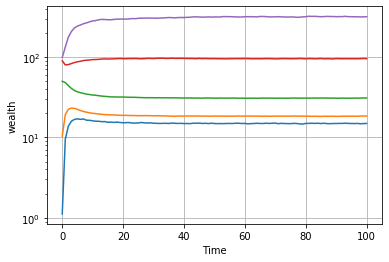

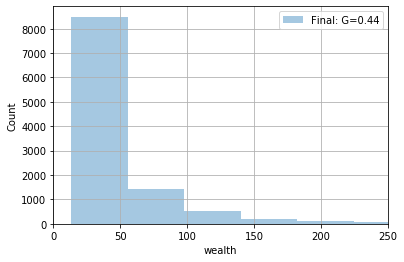

In [107]:
# sim = Any_Net(N=1500,network_f=small_world,transaction_f=Vickys)
# sim.show(metric="income")
# sim.show(metric="wealth")

# sim = Any_Net(N=200,network_f=BarbasiAlbert_Portugal,transaction_f=IPDO,max_pop=4000)
# sim.show(metric="wealth",nsteps=100)

# sim = Any_Net(N=1000,network_f=BarbasiAlbert_Portugal,transaction_f=IPDO,max_pop=4000)
# sim.show(metric="wealth",nsteps=100)

sim = Any_Net(N=11000,network_f=BarbasiAlbert_Portugal,transaction_f=IPDO,max_pop=4000)
sim.show(metric="wealth",nsteps=100)



# sim = Any_Net(N=1500,network_f=small_world_Portugal,transaction_f=IPDO_intgrowth,max_pop=200000)
# sim.show(metric="wealth",nsteps=100)

# sim = Any_Net(N=1500,network_f=small_world_Portugal,transaction_f=IPDO,max_pop=200000)
# sim.show(metric="wealth",nsteps=100)

# sim = Any_Net(N=1500,network_f=small_world,transaction_f=IPDO)
# sim.show(metric="wealth",nsteps=100)

# sim = Any_Net(N=1500,network_f=randnet,transaction_f=IPDO)
# sim.show(metric="wealth",nsteps=100)

# sim = Any_Net(N=1500,network_f=small_world)
# sim.show()

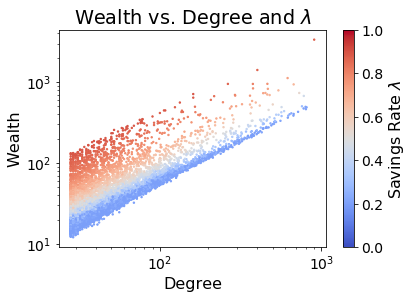

In [111]:
plt.rc('xtick', labelsize=14)     
plt.rc('ytick', labelsize=14)
# font = {'family' : 'normal',
#         #'weight' : 'bold',
#         'size'   : 16}
# plt.rc('font', **font)
plt.rcParams.update({'font.size': 16})


net = sim.network
degrees = []
wealths = []
lams = []
cmap = plt.cm.get_cmap('coolwarm')
for agent in list(net.nodes):
    degree = len(list(net.neighbors(agent)))
    wealth = net.nodes[agent]["wealth"]
    lam = net.nodes[agent]["lambda"]
    lams.append(lam)
    degrees.append(degree)
    wealths.append(wealth)
plt.scatter(degrees,wealths,c=cmap(lams),s=2)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Degree")
plt.ylabel("Wealth")
plt.title("Wealth vs. Degree and $\\lambda$")
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap))
cbar.set_label("Savings Rate $\\lambda$")


In [130]:
f_name = kem_name.replace(" ","") + net_name.replace(" ","") +"_04-18"
meta_sim.save_results(f_name)

finished populate
t= 20
t= 40
t= 60
t= 80
t= 100


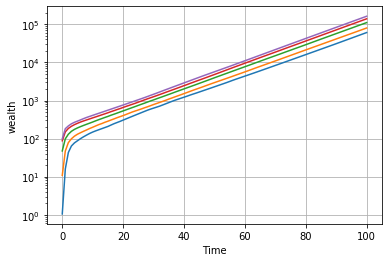

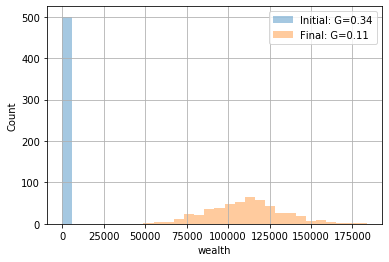

finished populate
t= 20
t= 40
t= 60
t= 80
t= 100


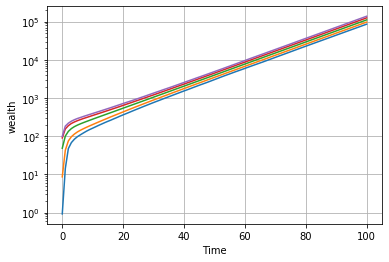

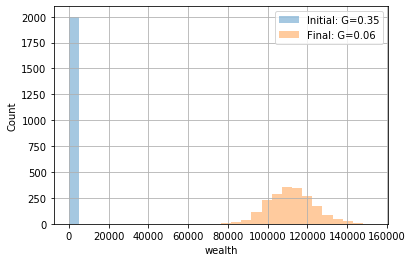

finished populate
t= 20
t= 40
t= 60
t= 80
t= 100


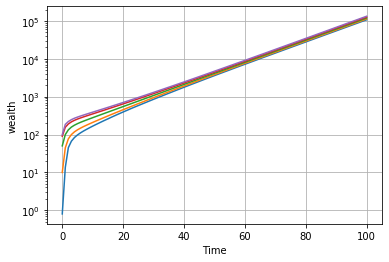

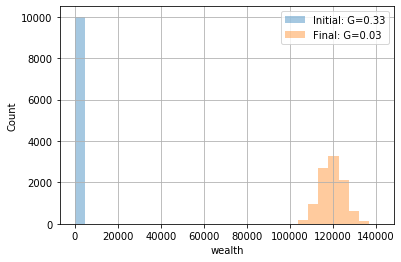

In [140]:
# sim = Any_Net(N=1500,network_f=small_world,transaction_f=Vickys)
# sim.show(metric="income")
# sim.show(metric="wealth")

sim = Any_Net(N=500,network_f=randnet,transaction_f=Vickys)
sim.show(metric="wealth",nsteps=100)

sim = Any_Net(N=2000,network_f=randnet,transaction_f=Vickys)
sim.show(metric="wealth",nsteps=100)

sim = Any_Net(N=10000,network_f=randnet,transaction_f=Vickys)
sim.show(metric="wealth",nsteps=100)

# sim = Any_Net(N=500,network_f=small_world_Portugal,transaction_f=IPDO_intgrowth)
# sim.show(metric="wealth",nsteps=100)

# sim = Any_Net(N=10000,network_f=small_world_Portugal,transaction_f=IPDO_intgrowth)
# sim.show(metric="wealth",nsteps=100)

# sim = Any_Net(N=1500,network_f=small_world,transaction_f=IPDO)
# sim.show(metric="wealth",nsteps=100)

# sim = Any_Net(N=1500,network_f=randnet,transaction_f=IPDO)
# sim.show(metric="wealth",nsteps=100)

# sim = Any_Net(N=1500,network_f=small_world)
# sim.show()

pop: 2000
<k>= 48.0
sigma_k*= 0.28347431855435523


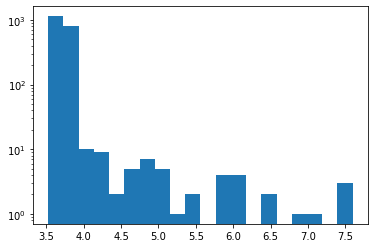

<C>= 0.5094864352414897
pop: 2000
<k>= 48.0
sigma_k*= 0.2784393607788518


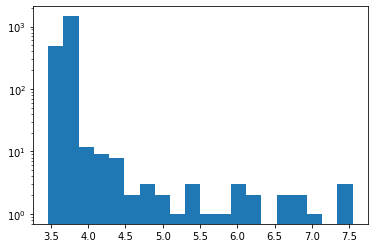

<C>= 0.5194551081370843
pop: 2000


In [ ]:
### small-world network analysis (to conform to Portugal paper)


# def HolmeKim_Portugal(n,max_pop=None):
#     beta_k = 0.12 # FROM PORTUGAL PAPER

#     max_k = 12

#     y0_k = max_k/(max_pop**beta_k)
#     k = int(y0_k*n**beta_k)
#     m = int(k/2)
#     print("m:",m)
#     # https://arxiv.org/pdf/cond-mat/0110452.pdf
#     p = 3.*(1/(m-1))
#     print("p:",p)
#     return nx.powerlaw_cluster_graph(n, m, p, seed=None)


def createSkewDist(mean, sd, skew, size):

    # calculate the degrees of freedom 1 required to obtain the specific skewness statistic, derived from simulations
    loglog_slope=-2.211897875506251 
    loglog_intercept=1.002555437670879 
    df2=500
    df1 = 10**(loglog_slope*np.log10(abs(skew)) + loglog_intercept)

    # sample from F distribution
    fsample = np.sort(scipy.stats.f(df1, df2).rvs(size=size))

    # adjust the variance by scaling the distance from each point to the distribution mean by a constant, derived from simulations
    k1_slope = 0.5670830069364579
    k1_intercept = -0.09239985798819927
    k2_slope = 0.5823114978219056
    k2_intercept = -0.11748300123471256

    scaling_slope = abs(skew)*k1_slope + k1_intercept
    scaling_intercept = abs(skew)*k2_slope + k2_intercept

    scale_factor = (sd - scaling_intercept)/scaling_slope    
    new_dist = (fsample - np.mean(fsample))*scale_factor + fsample

    # flip the distribution if specified skew is negative
    if skew < 0:
        new_dist = np.mean(new_dist) - new_dist

    # adjust the distribution mean to the specified value
    final_dist = new_dist + (mean - np.mean(new_dist))

    return final_dist




# def lognorm(x):
#     loc = 0
#     scale = 1 
#     shape = 0.5
#     y = np.log(x)
#     return scipy.stats.skewnorm.pdf(y,shape,loc,scale)

# class lognorm_gen(scipy.stats.rv_continuous):
# #     def __init__(loc,pop,shape):
# #         self.loc=loc
# #         self.pop=pop
# #         sel.shape=shape
        
#     def _pdf(self, x):
#         return lognorm(x)

    
# # lognorm_rv = lognorm_gen(name='lognorm')
# # rvs = lognorm_rv.rvs(size=5)
# # print("made rvs")
# # print(rvs)
    
    
    
def modified_watts_strogatz_graph(net, k, p):

    G = net
    nodes = list(net.nodes) # nodes are labeled 0 to n-1
    
    ### pdf over nodes of rewiring probability taken from a skewed lognormal distribution (see the portugal paper***)
    desired_mean = np.log(k*100)
    desired_skew = 0.2#*np.log(100)
    desired_sd = 0.9*np.log(100)
#     biases = np.random.beta(2,5,len(nodes))
    biases = np.random.lognormal(sigma=6.,size=len(nodes))

#     print("biases")
#     plt.hist(np.log(biases))
    plt.show()
    plt.close()
#     set_trace()
    #createSkewDist(mean=desired_mean, sd=desired_sd, skew=desired_skew, size=len(nodes))
#     biases = np.exp(biases)
#     plt.hist(biases)
    #convert to pdf prop. to desired k-value per node
    biases *= 1/np.sum(biases)
#     plt.hist(biases)
    
#     print(biases)
    
    # rewire edges from each node
    # loop over all nodes in order (label) and neighbors in order (distance)
    # no self loops or multiple edges allowed
    for j in range(1, int(k) // 2+1): # outer loop is neighbors
#         set_trace()
        targets = nodes[j:] + nodes[0:j] # first j nodes are now last in list
        
        # inner loop in node order
        for u,v in zip(nodes,targets):
            ### UNwire here with probability proportional to popularity OR just leave it as p
            if random.random() < p:
                w = np.random.choice(nodes,p=biases)
                # Enforce no self-loops or multiple edges
                while w == u or G.has_edge(u, w):
                    ### Choose here to REWIRE, giving choice function a set of probability weights
                    w = np.random.choice(nodes,p=biases)
#                     w = random.choice(nodes)
                    if G.degree(u) >= n-1:
                        break # skip this rewiring
                else:
                    G.remove_edge(u,v)
#                     G.add_edge(u,w)
                    G.add_edge(u,w)
    return G


beta_k = 0.12 # FROM PORTUGAL PAPER

max_k = 60
max_pop = 10000

y0_k = max_k/(max_pop**beta_k)
# pops = [4000,2500,1000,500,300]
pops = [2000,3000,4000,5000,6000,7000,8000]
for n in pops:
    # reproducing to see how variant the CC is
    CC = []
    for _ in range(3):
        print("pop:",n)
        k = y0_k*n**beta_k
        p = 0.3 #0.3 creates <C> ~ .26
        net =  nx.watts_strogatz_graph(n,int(k),0.)
        net = modified_watts_strogatz_graph(net,k,p)
        
#         net = BarbasiAlbert_static(n)
        k_dist = [len(list(net.neighbors(x))) for x in net.nodes]
#         plt.hist(k_dist,bins=20)
        print("<k>=",np.average(k_dist))
#         print("sigma_k=",np.std(k_dist))
        logk_dist = [np.log(len(list(net.neighbors(x)))) for x in net.nodes]
        plt.hist(logk_dist,bins=20)
#         print("<k*>=",np.average(logk_dist))
        print("sigma_k*=",np.std(logk_dist))
        plt.yscale("log")
        plt.show()
        CC_ = nx.average_clustering(net)
        CC.append(CC_)
        print("<C>=",CC_)
        plt.close()
    print(np.average(CC))

RUNNING NOW ON HOMOGENOUS INITIAL POPULATIONS



 KEM =  Productivity Generation 
 NETWORK =  Small World Network; k=50, p=0.01
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.13542628022541472
   t    Gini stdev   1%  10%  50%  90%  99%


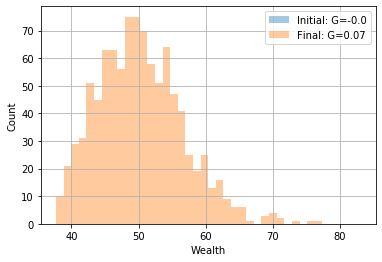

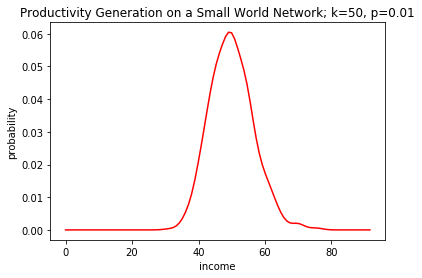




 KEM =  Productivity Generation 
 NETWORK =  Random Network
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.1314988303928998
   t    Gini stdev   1%  10%  50%  90%  99%


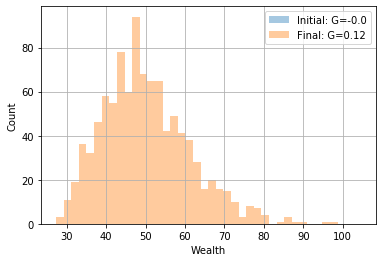

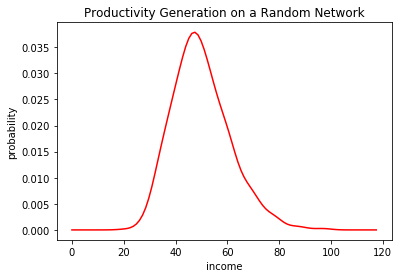




 KEM =  Productivity Generation 
 NETWORK =  Small World Network; k=50, p=0.0001
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.13534634731083453
   t    Gini stdev   1%  10%  50%  90%  99%


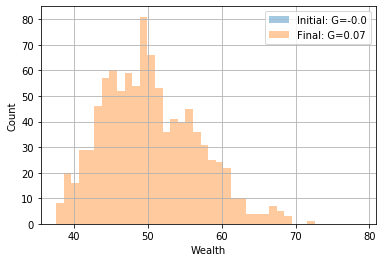

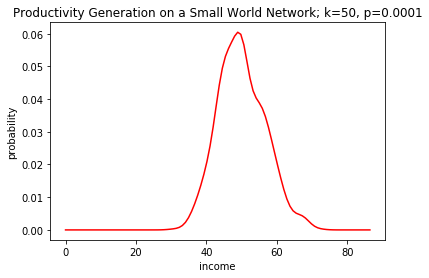




 KEM =  Productivity Generation 
 NETWORK =  Segregated Network; 4 clusters
running populate
building network
4 250
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.13518956950898348
   t    Gini stdev   1%  10%  50%  90%  99%


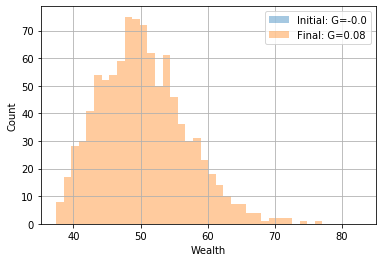

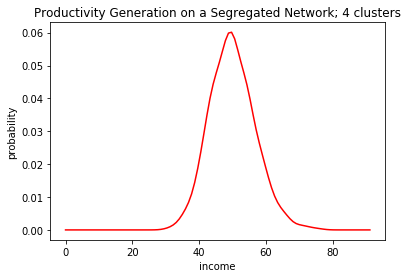




 KEM =  Productivity Generation 
 NETWORK =  Segregated Network; 30 clusters
running populate
building network
30 33
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.13391439059494453
   t    Gini stdev   1%  10%  50%  90%  99%


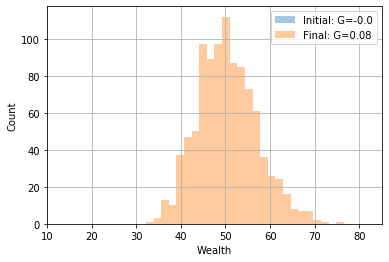

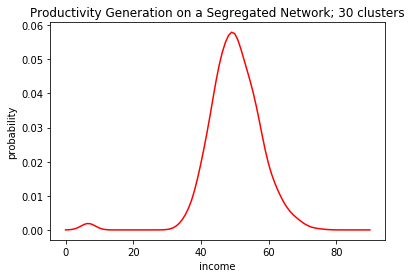




 KEM =  Additive Generation KEM 
 NETWORK =  Small World Network; k=50, p=0.01
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.047618140606845584
   t    Gini stdev   1%  10%  50%  90%  99%


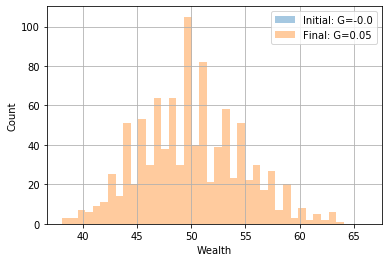

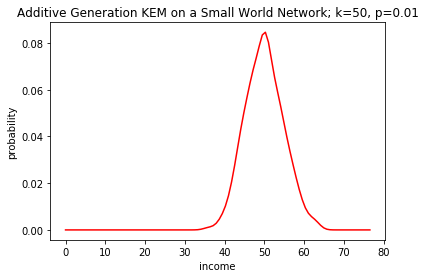




 KEM =  Additive Generation KEM 
 NETWORK =  Random Network
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.047618140606845584
   t    Gini stdev   1%  10%  50%  90%  99%


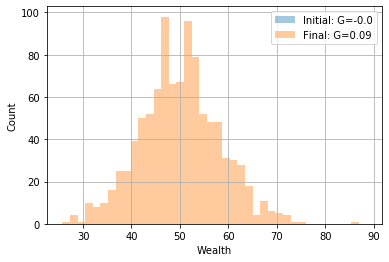

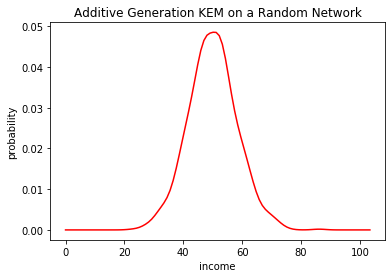




 KEM =  Additive Generation KEM 
 NETWORK =  Small World Network; k=50, p=0.0001
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.047618140606845584
   t    Gini stdev   1%  10%  50%  90%  99%


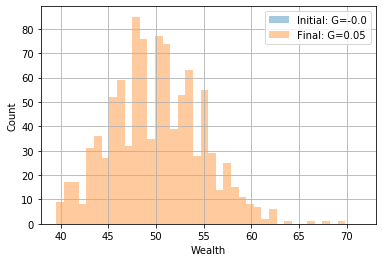

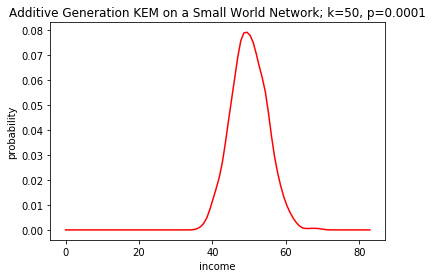




 KEM =  Additive Generation KEM 
 NETWORK =  Segregated Network; 4 clusters
running populate
building network
4 250
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.047618140606845584
   t    Gini stdev   1%  10%  50%  90%  99%


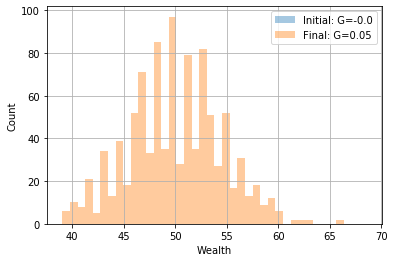

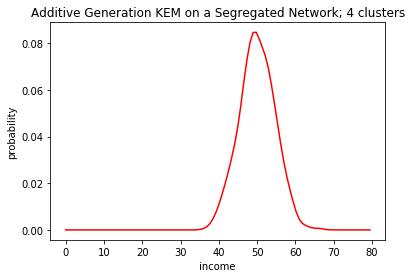




 KEM =  Additive Generation KEM 
 NETWORK =  Segregated Network; 30 clusters
running populate
building network
30 33
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.047618140606845584
   t    Gini stdev   1%  10%  50%  90%  99%


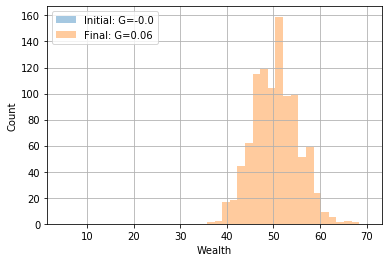

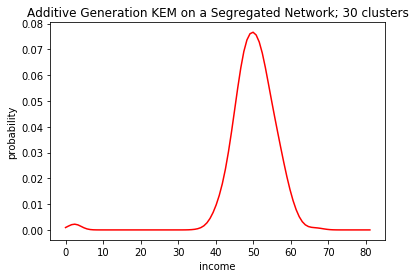

RUNNING NOW ON NORMALLY DISTRIBUTED INITIAL POPULATIONS



 KEM =  IPDO 
 NETWORK =  Small World Network; k=50, p=0.01
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.9999999999999981
   t    Gini stdev   1%  10%  50%  90%  99%


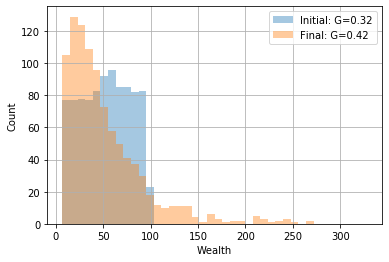

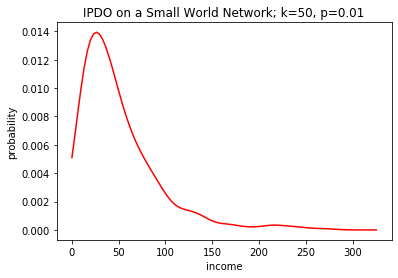




 KEM =  IPDO 
 NETWORK =  Random Network
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.9999999999999991
   t    Gini stdev   1%  10%  50%  90%  99%


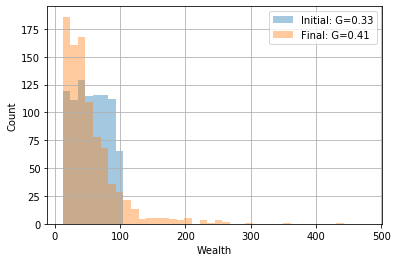

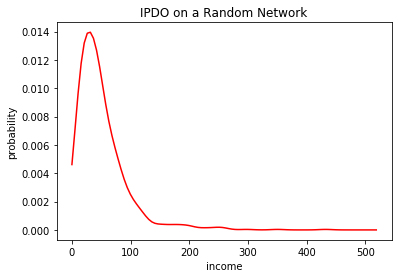




 KEM =  IPDO 
 NETWORK =  Small World Network; k=50, p=0.0001
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.9999999999999987
   t    Gini stdev   1%  10%  50%  90%  99%


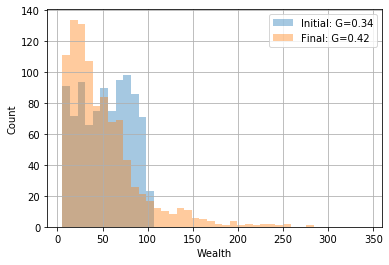

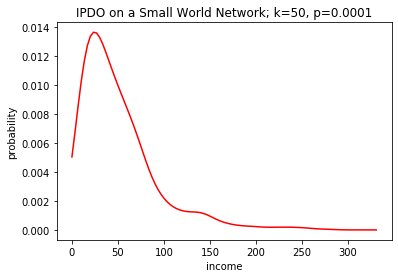




 KEM =  IPDO 
 NETWORK =  Segregated Network; 4 clusters
running populate
building network
4 250
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.999999999999998
   t    Gini stdev   1%  10%  50%  90%  99%


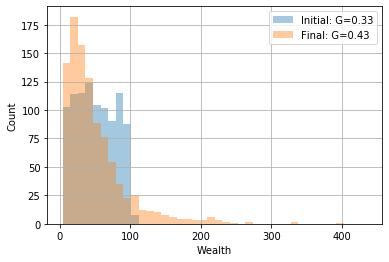

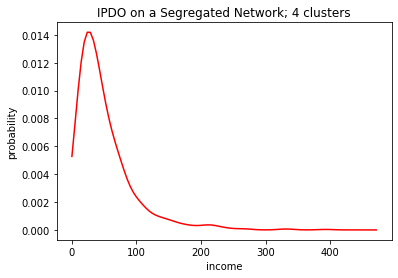




 KEM =  IPDO 
 NETWORK =  Segregated Network; 30 clusters
running populate
building network
30 33
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  1.0000000000000013
   t    Gini stdev   1%  10%  50%  90%  99%


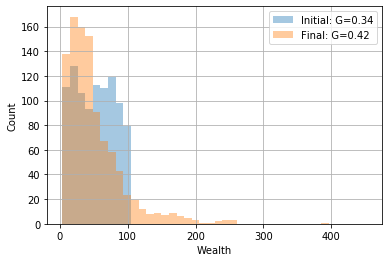

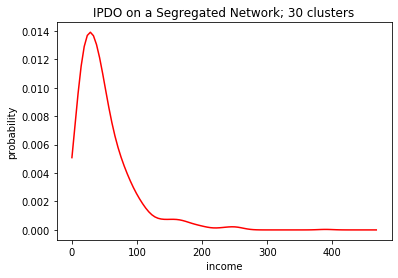




 KEM =  Vicky's KEM 
 NETWORK =  Small World Network; k=50, p=0.01
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.6189541373691848
   t    Gini stdev   1%  10%  50%  90%  99%


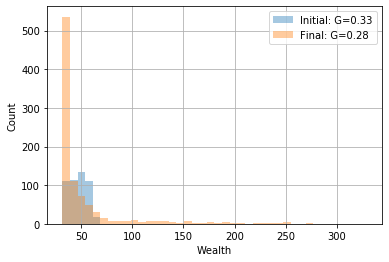

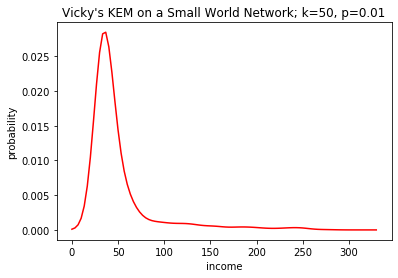




 KEM =  Vicky's KEM 
 NETWORK =  Random Network
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.6349491527457366
   t    Gini stdev   1%  10%  50%  90%  99%


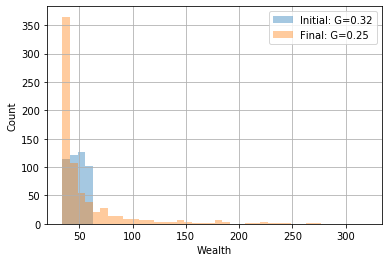

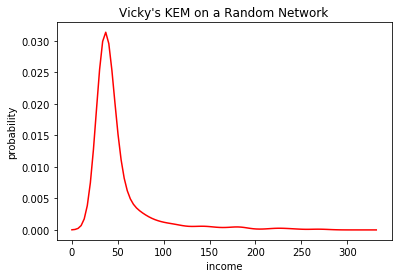




 KEM =  Vicky's KEM 
 NETWORK =  Small World Network; k=50, p=0.0001
running populate
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.6247528950671103
   t    Gini stdev   1%  10%  50%  90%  99%


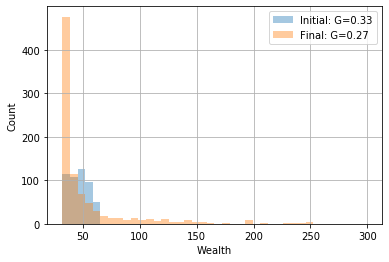

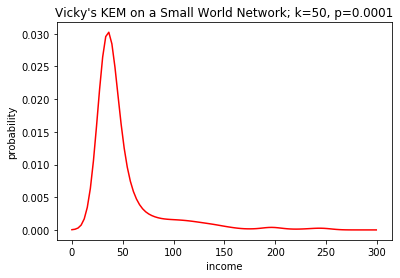




 KEM =  Vicky's KEM 
 NETWORK =  Segregated Network; 4 clusters
running populate
building network
4 250
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.6181853787230185
   t    Gini stdev   1%  10%  50%  90%  99%


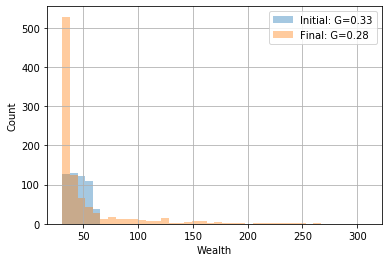

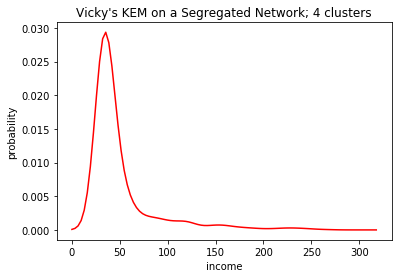




 KEM =  Vicky's KEM 
 NETWORK =  Segregated Network; 30 clusters
running populate
building network
30 33
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.6380472936632108
   t    Gini stdev   1%  10%  50%  90%  99%


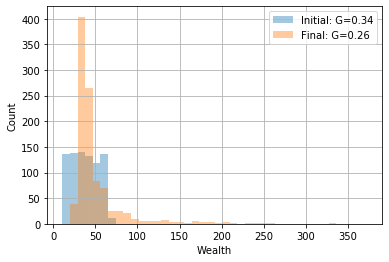

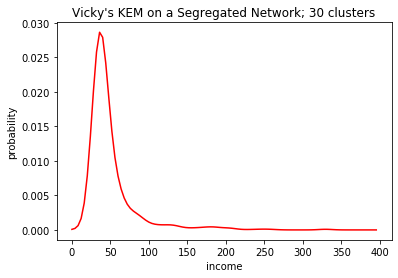

In [12]:
# kems = {
    "IPDO":IPDO,
    "Vicky's KEM":vickys_KEM
    #"Productivity Generation":productivity_gen
}

nets = {
    "Small World Network; k=50, p=0.01":small_world,
    "Random Network":randnet,
    "Small World Network; k=50, p=0.0001":lambda n: nx.connected_watts_strogatz_graph(n, 50, 0.0001),
    "Segregated Network; 4 clusters":lambda n: segregated(n,4),
    "Segregated Network; 30 clusters":lambda n: segregated(n,30)
}

print("RUNNING NOW ON HOMOGENOUS INITIAL POPULATIONS")
for kem_name,kem in zip(["Productivity Generation","Additive Generation KEM"],[productivity_gen,additive_gen_KEM]):
    for net_name in nets:
#         kem = kems[kem_name]
        net = nets[net_name]
        print("\n\n\n KEM = ",kem_name,"\n NETWORK = ",net_name)
        title = kem_name + " on a " + net_name
        sim = HomoPop_Net(N=1000,transaction_f=kem,network_f=net)
        print("made sim!")
        sim.normalize(silence=True)
        sim.run(convergence="manual",k=100)
        sim.normalize()
        sim.show()
        sim.kde_dist(title=title)

print("RUNNING NOW ON NORMALLY DISTRIBUTED INITIAL POPULATIONS")
for kem_name in kems:
    for net_name in nets:
        kem = kems[kem_name]
        net = nets[net_name]
        print("\n\n\n KEM = ",kem_name,"\n NETWORK = ",net_name)
        title = kem_name + " on a " + net_name
        sim = Any_Net(N=1000,transaction_f=kem,network_f=net)
        print("made sim!")
        sim.normalize(silence=True)
        sim.run(convergence="manual",k=100)
        sim.normalize()
        sim.show()
        sim.kde_dist(title=title)
    

      

        

RUNNING NOW ON HOMOGENOUS INITIAL POPULATIONS



 KEM =  Productivity Generation 
 NETWORK =  Small World Network; k=50, p=0.01
running populate
building network
finished building network
finished populate
made sim!
final time:  250000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
finished
norm_factor =  0.13533030820314582
   t    Gini stdev   1%  10%  50%  90%  99%


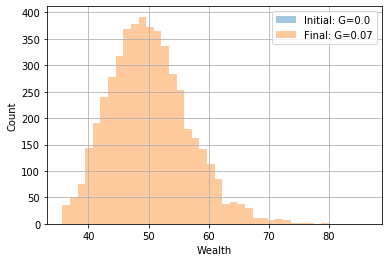

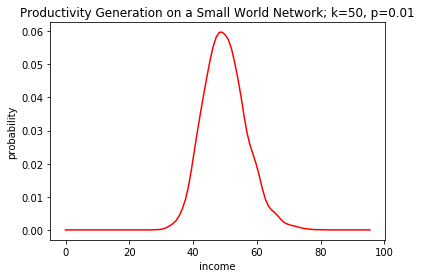




 KEM =  Productivity Generation 
 NETWORK =  Random Network
running populate
building network
finished building network
finished populate
made sim!
final time:  250000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
finished
norm_factor =  0.13460084231519628
   t    Gini stdev   1%  10%  50%  90%  99%


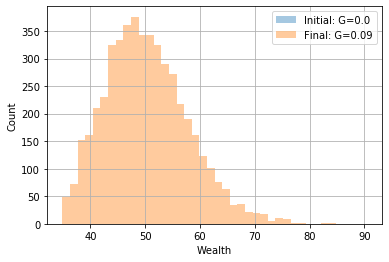

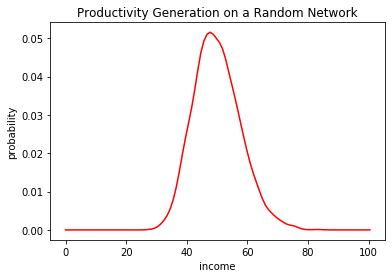




 KEM =  Productivity Generation 
 NETWORK =  Small World Network; k=50, p=0.0001
running populate
building network
finished building network
finished populate
made sim!
final time:  250000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
finished
norm_factor =  0.1353819064666694
   t    Gini stdev   1%  10%  50%  90%  99%


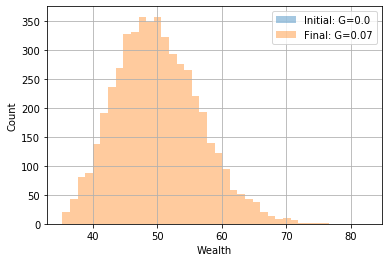

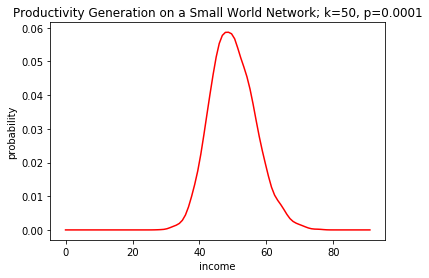




 KEM =  Productivity Generation 
 NETWORK =  Segregated Network; 4 clusters
running populate
building network
4 1250
finished building network
finished populate
made sim!
final time:  250000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
finished
norm_factor =  0.13539884652274523
   t    Gini stdev   1%  10%  50%  90%  99%


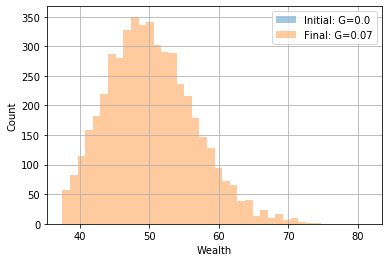

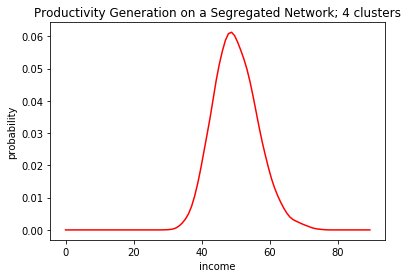




 KEM =  Productivity Generation 
 NETWORK =  Segregated Network; 30 clusters
running populate
building network
30 166
finished building network
finished populate
made sim!
final time:  250000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
finished
norm_factor =  0.13470312663292344
   t    Gini stdev   1%  10%  50%  90%  99%


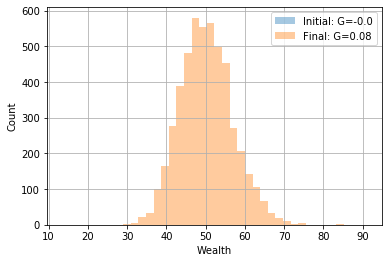

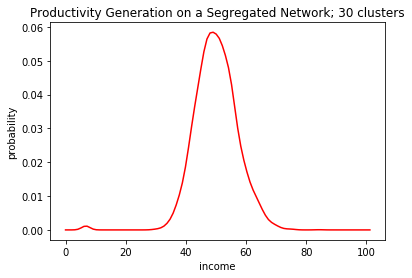




 KEM =  Additive Generation KEM 
 NETWORK =  Small World Network; k=50, p=0.01
running populate
building network
finished building network
finished populate
made sim!
final time:  250000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
finished
norm_factor =  0.047618866213842995
   t    Gini stdev   1%  10%  50%  90%  99%


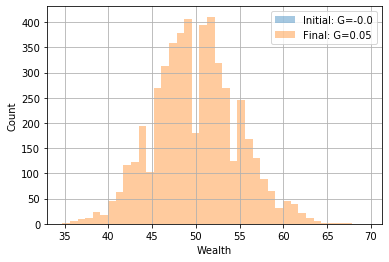

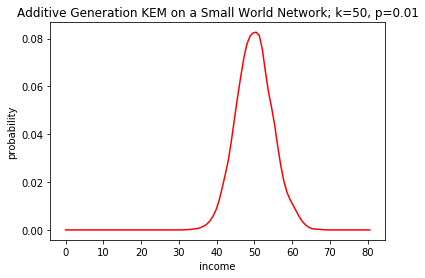




 KEM =  Additive Generation KEM 
 NETWORK =  Random Network
running populate
building network
finished building network
finished populate
made sim!
final time:  250000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
finished
norm_factor =  0.047618866213842995
   t    Gini stdev   1%  10%  50%  90%  99%


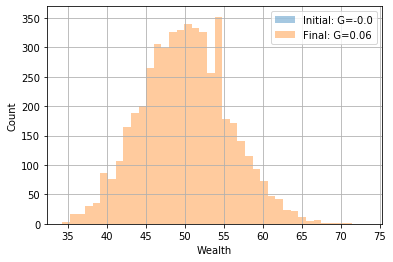

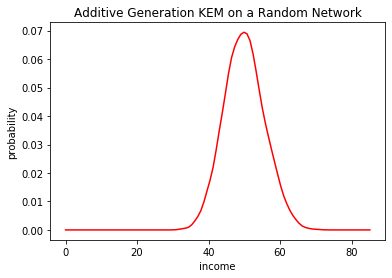




 KEM =  Additive Generation KEM 
 NETWORK =  Small World Network; k=50, p=0.0001
running populate
building network
finished building network
finished populate
made sim!
final time:  250000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
finished
norm_factor =  0.047618866213842995
   t    Gini stdev   1%  10%  50%  90%  99%


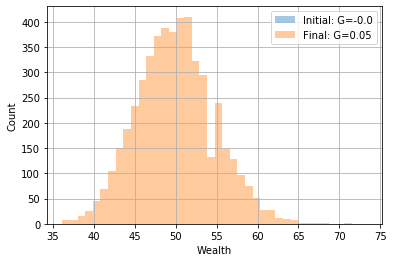

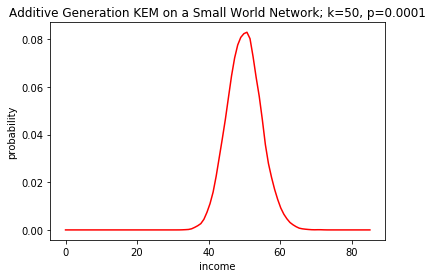




 KEM =  Additive Generation KEM 
 NETWORK =  Segregated Network; 4 clusters
running populate
building network
4 1250
finished building network
finished populate
made sim!
final time:  250000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
finished
norm_factor =  0.047618866213842995
   t    Gini stdev   1%  10%  50%  90%  99%


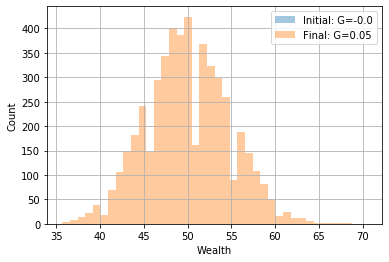

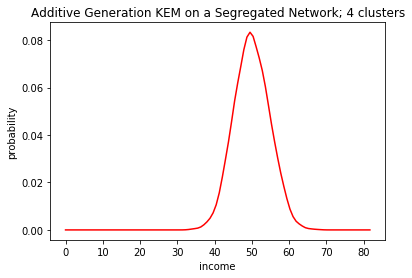




 KEM =  Additive Generation KEM 
 NETWORK =  Segregated Network; 30 clusters
running populate
building network
30 166
finished building network
finished populate
made sim!
final time:  250000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
finished
norm_factor =  0.047618866213842995
   t    Gini stdev   1%  10%  50%  90%  99%


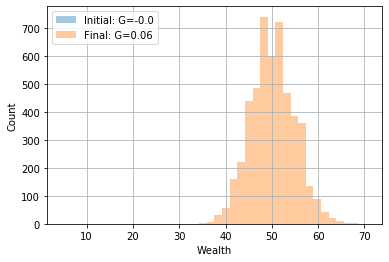

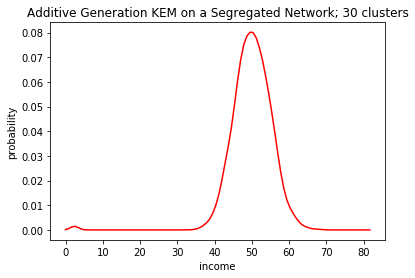

RUNNING NOW ON NORMALLY DISTRIBUTED INITIAL POPULATIONS



 KEM =  IPDO 
 NETWORK =  Small World Network; k=50, p=0.01
running populate
building network
finished building network
finished populate
made sim!
final time:  375000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
at t: 255000
at t: 260000
at t: 265000
at t: 270000
at t: 275000
at t: 280000
at t: 285000
at t: 290000
at t: 295000
at t: 300000
at 

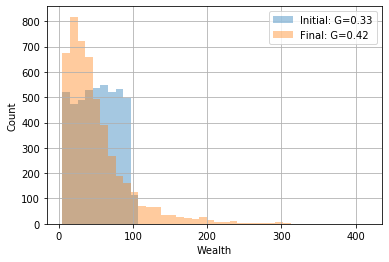

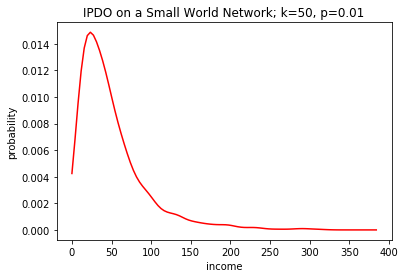




 KEM =  IPDO 
 NETWORK =  Random Network
running populate
building network
finished building network
finished populate
made sim!
final time:  375000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
at t: 255000
at t: 260000
at t: 265000
at t: 270000
at t: 275000
at t: 280000
at t: 285000
at t: 290000
at t: 295000
at t: 300000
at t: 305000
at t: 310000
at t: 315000
at t: 320000
at t: 325000
at t: 330000


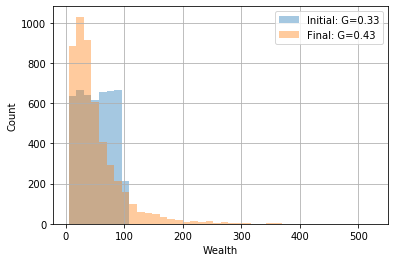

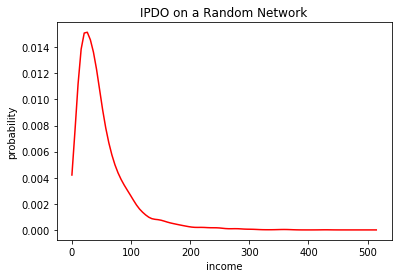




 KEM =  IPDO 
 NETWORK =  Small World Network; k=50, p=0.0001
running populate
building network
finished building network
finished populate
made sim!
final time:  375000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
at t: 255000
at t: 260000
at t: 265000
at t: 270000
at t: 275000
at t: 280000
at t: 285000
at t: 290000
at t: 295000
at t: 300000
at t: 305000
at t: 310000
at t: 315000
at t: 320000
at t:

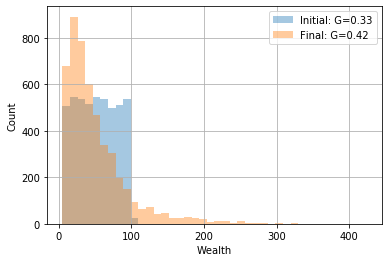

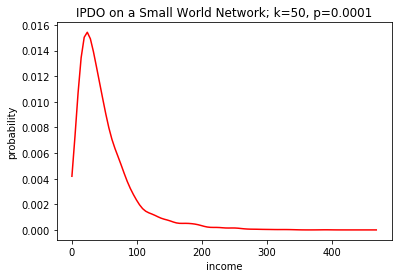




 KEM =  IPDO 
 NETWORK =  Segregated Network; 4 clusters
running populate
building network
4 1250
finished building network
finished populate
made sim!
final time:  375000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
at t: 255000
at t: 260000
at t: 265000
at t: 270000
at t: 275000
at t: 280000
at t: 285000
at t: 290000
at t: 295000
at t: 300000
at t: 305000
at t: 310000
at t: 315000
at t: 320000
at 

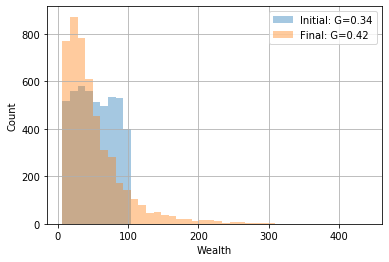

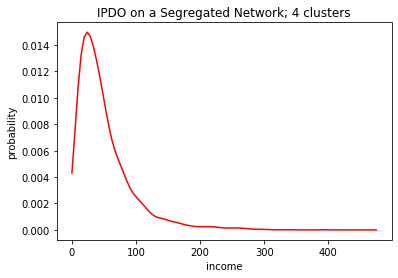




 KEM =  IPDO 
 NETWORK =  Segregated Network; 30 clusters
running populate
building network
30 166
finished building network
finished populate
made sim!
final time:  375000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
at t: 255000
at t: 260000
at t: 265000
at t: 270000
at t: 275000
at t: 280000
at t: 285000
at t: 290000
at t: 295000
at t: 300000
at t: 305000
at t: 310000
at t: 315000
at t: 320000
at

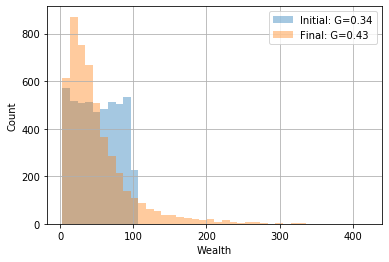

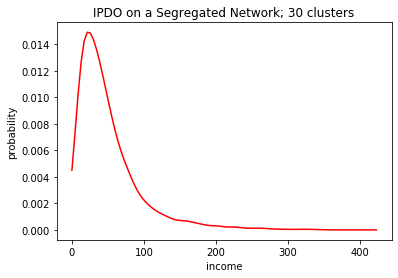




 KEM =  Vicky's KEM 
 NETWORK =  Small World Network; k=50, p=0.01
running populate
building network
finished building network
finished populate
made sim!
final time:  375000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
at t: 255000
at t: 260000
at t: 265000
at t: 270000
at t: 275000
at t: 280000
at t: 285000
at t: 290000
at t: 295000
at t: 300000
at t: 305000
at t: 310000
at t: 315000
at t: 320000


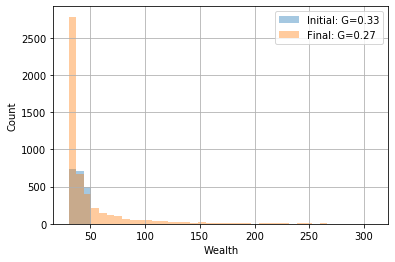

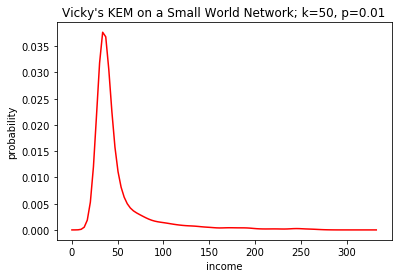




 KEM =  Vicky's KEM 
 NETWORK =  Random Network
running populate
building network
finished building network
finished populate
made sim!
final time:  375000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
at t: 255000
at t: 260000
at t: 265000
at t: 270000
at t: 275000
at t: 280000
at t: 285000
at t: 290000
at t: 295000
at t: 300000
at t: 305000
at t: 310000
at t: 315000
at t: 320000
at t: 325000
at t: 

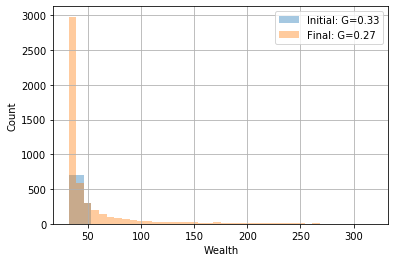

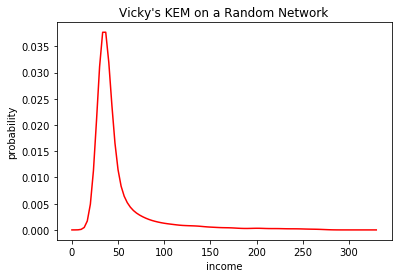




 KEM =  Vicky's KEM 
 NETWORK =  Small World Network; k=50, p=0.0001
running populate
building network
finished building network
finished populate
made sim!
final time:  375000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
at t: 55000
at t: 60000
at t: 65000
at t: 70000
at t: 75000
at t: 80000
at t: 85000
at t: 90000
at t: 95000
at t: 100000
at t: 105000
at t: 110000
at t: 115000
at t: 120000
at t: 125000
at t: 130000
at t: 135000
at t: 140000
at t: 145000
at t: 150000
at t: 155000
at t: 160000
at t: 165000
at t: 170000
at t: 175000
at t: 180000
at t: 185000
at t: 190000
at t: 195000
at t: 200000
at t: 205000
at t: 210000
at t: 215000
at t: 220000
at t: 225000
at t: 230000
at t: 235000
at t: 240000
at t: 245000
at t: 250000
at t: 255000
at t: 260000
at t: 265000
at t: 270000
at t: 275000
at t: 280000
at t: 285000
at t: 290000
at t: 295000
at t: 300000
at t: 305000
at t: 310000
at t: 315000


In [ ]:
kems = {
    "IPDO":IPDO,
    "Vicky's KEM":vickys_KEM
    #"Productivity Generation":productivity_gen
}

nets = {
    "Small World Network; k=50, p=0.01":small_world,
    "Random Network":randnet,
    "Small World Network; k=50, p=0.0001":lambda n: nx.connected_watts_strogatz_graph(n, 50, 0.0001),
    "Segregated Network; 4 clusters":lambda n: segregated(n,4),
    "Segregated Network; 30 clusters":lambda n: segregated(n,30)
}

print("RUNNING NOW ON HOMOGENOUS INITIAL POPULATIONS")
for kem_name,kem in zip(["Productivity Generation","Additive Generation KEM"],[productivity_gen,additive_gen_KEM]):
    for net_name in nets:
#         kem = kems[kem_name]
        net = nets[net_name]
        print("\n\n\n KEM = ",kem_name,"\n NETWORK = ",net_name)
        title = kem_name + " on a " + net_name
        sim = HomoPop_Net(N=5000,transaction_f=kem,network_f=net)
        print("made sim!")
        sim.normalize(silence=True)
        sim.run(convergence="manual",k=100)
        sim.normalize()
        sim.show()
        sim.kde_dist(title=title)

print("RUNNING NOW ON NORMALLY DISTRIBUTED INITIAL POPULATIONS")
for kem_name in kems:
    for net_name in nets:
        kem = kems[kem_name]
        net = nets[net_name]
        print("\n\n\n KEM = ",kem_name,"\n NETWORK = ",net_name)
        title = kem_name + " on a " + net_name
        sim = Any_Net(N=5000,transaction_f=kem,network_f=net)
        print("made sim!")
        sim.normalize(silence=True)
        sim.run(convergence="manual",k=150)
        sim.normalize()
        sim.show()
        sim.kde_dist(title=title)
    

      

        

In [90]:
kems = {
#     "IPDO":IPDO,
    "Vicky's KEM":vickys_KEM
    #"Productivity Generation":productivity_gen
}

nets = {
#     "Small World Network; k=50, p=0.01":small_world,
    "Random Network":randnet,
    "Small World Network; k=50, p=0.0001":lambda n: nx.connected_watts_strogatz_graph(n, 50, 0.0001),
    "Segregated Network; 4 clusters":lambda n: segregated(n,4),
    "Segregated Network; 30 clusters":lambda n: segregated(n,30)
}

# print("RUNNING NOW ON HOMOGENOUS INITIAL POPULATIONS")
# for kem_name,kem in zip(["Productivity Generation","Additive Generation KEM"],[productivity_gen,additive_gen_KEM]):
#     for net_name in nets:
# #         kem = kems[kem_name]
#         net = nets[net_name]
#         print("\n\n\n KEM = ",kem_name,"\n NETWORK = ",net_name)
#         title = kem_name + " on a " + net_name
#         sim = HomoPop_Net(N=5000,transaction_f=kem,network_f=net)
#         print("made sim!")
#         sim.normalize(silence=True)
#         sim.run(convergence="manual",k=100)
#         sim.normalize()
#         sim.show()
#         sim.kde_dist(title=title)

print("RUNNING NOW ON NORMALLY DISTRIBUTED INITIAL POPULATIONS")
for kem_name in kems:
    for net_name in nets:
        kem = kems[kem_name]
        net = nets[net_name]
        print("\n\n\n KEM = ",kem_name,"\n NETWORK = ",net_name)
        title = kem_name + " on a " + net_name
        sim = Any_Net(N=5000,transaction_f=kem,network_f=net)
        print("made sim!")
        sim.normalize(silence=True)
        sim.run(convergence="manual",k=150)
        sim.normalize()
        sim.show()
        sim.kde_dist(title=title)
    

      

        

NameError: name 'vickys_KEM' is not defined

RUNNING NOW ON HOMOGENOUS INITIAL POPULATIONS



 KEM =  Productivity Generation 
 NETWORK =  Random Network
running populate
mu: 50.0 n: 1000
building network
finished building network
finished populate
made sim!
final time:  50000.0
at t: 0
at t: 5000
at t: 10000
at t: 15000
at t: 20000
at t: 25000
at t: 30000
at t: 35000
at t: 40000
at t: 45000
at t: 50000
finished
norm_factor =  0.13145707158403905
   t    Gini stdev   1%  10%  50%  90%  99%


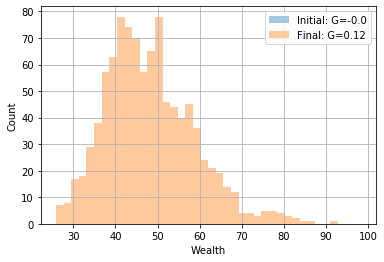

ValueError: autodetected range of [nan, nan] is not finite

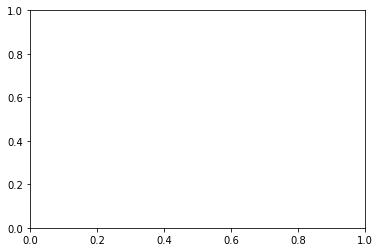

In [11]:
kems = {
#     "IPDO":IPDO,
    "Vicky's KEM":vickys_KEM
    #"Productivity Generation":productivity_gen
}

nets = {
#     "Small World Network; k=50, p=0.01":small_world,
    "Random Network":randnet,
    "Small World Network; k=50, p=0.0001":lambda n: nx.connected_watts_strogatz_graph(n, 50, 0.0001),
    "Segregated Network; 4 clusters":lambda n: segregated(n,4),
    "Segregated Network; 30 clusters":lambda n: segregated(n,30)
}

print("RUNNING NOW ON HOMOGENOUS INITIAL POPULATIONS")
for kem_name,kem in zip(["Productivity Generation","Additive Generation KEM"],[productivity_gen,additive_gen_KEM]):
    for net_name in nets:
#         kem = kems[kem_name]
        net = nets[net_name]
        print("\n\n\n KEM = ",kem_name,"\n NETWORK = ",net_name)
        title = kem_name + " on a " + net_name
        sim = HomoPop_Net(N=1000,transaction_f=kem,network_f=net)
        print("made sim!")
        sim.normalize(silence=True)
        sim.run(convergence="manual",k=100,only_final=False)
        sim.normalize()
        sim.show()
#         sim.kde_dist(title=title)
        anim = sim.animate_distributions(times=[0,100*1000/2],n_frames=100,average=True)
        HTML(anim.to_jshtml())

print("RUNNING NOW ON NORMALLY DISTRIBUTED INITIAL POPULATIONS")
for kem_name in kems:
    for net_name in nets:
        kem = kems[kem_name]
        net = nets[net_name]
        print("\n\n\n KEM = ",kem_name,"\n NETWORK = ",net_name)
        title = kem_name + " on a " + net_name
        sim = Any_Net(N=1000,transaction_f=kem,network_f=net)
        print("made sim!")
        sim.normalize(silence=True)
        sim.run(convergence="manual",k=150,only_final=False)
        sim.normalize()
        sim.show()
#         sim.kde_dist(title=title)
        anim = sim.animate_distributions(self,times=[0,40000],n_frames=10,average=True)
        HTML(anim.to_jshtml())
    

      

        

In [ ]:
sim = Pure_Random(N=100,mu=50.)
populations=[250,1000,1000,2000,2000,3000,3000,4000,4500,5000,5500,6000,7000,7500,8000,8500,9000,10000,13000,15000]
# converge_params=[0.2,0.006,0.04]
converge_params=[0.0075]
converge_times = []
for pop in populations:
    print("\n\n NEW SIM. POPULATION = %s"%pop)
    sim.reset()
    sim.populate(n=pop,mu=sim.mu)
    sim.run(convergence="auto",debug=True,auto_converge_params=converge_params)
    dmdtvals = np.array(sim.dmdt_vals)
    #m2s,m3s,m4s = dmdtvals[:,0],dmdtvals[:,1],dmdtvals[:,2]
    m3s = dmdtvals[:,0]#,dmdtvals[:,1],dmdtvals[:,2]
    t = list(range(len(m3s)))
#     plt.figure()
#     plt.plot(t,m2s)
#     plt.title("2nd moment")
#     plt.show()
#     plt.close()
    plt.figure()
    plt.title("3rd moment")
    plt.plot(t,m3s)
    plt.show()
    plt.close()
    
    
    
    converge_times.append(sim.convergence_t)
#     plt.figure()
#     plt.plot(t,m4s)
#     plt.title("4th moment")
#     plt.show()
#     plt.close()
#     anim = sim.animate_distributions(times=[1,t[-2]],n_frames=50)
#     HTML(anim.to_jshtml())

#     sim.show()
#     print("RUNNING TO MAX:")
#     sim.reset()
#     sim.populate(n=pop,mu=sim.mu)
#     sim.run(convergence="manual")
#     sim.show()
            

final time:  20000.0
at t: 0
at t: 500
at t: 1000
at t: 1500
at t: 2000
at t: 2500
at t: 3000
at t: 3500
at t: 4000
at t: 4500
at t: 5000
at t: 5500
at t: 6000
at t: 6500
at t: 7000
at t: 7500
at t: 8000
at t: 8500
at t: 9000
at t: 9500
at t: 10000
at t: 10500
at t: 11000
at t: 11500
at t: 12000
at t: 12500
at t: 13000
at t: 13500
at t: 14000
at t: 14500
at t: 15000
at t: 15500
at t: 16000
at t: 16500
at t: 17000
at t: 17500
at t: 18000
at t: 18500
at t: 19000
at t: 19500
at t: 20000
finished
20000


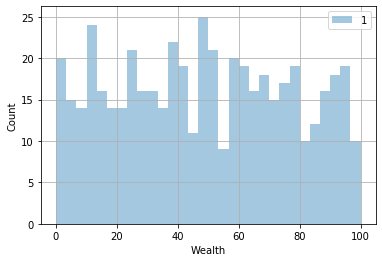

In [14]:
p = 500
sim = Pure_Random(N=p,mu=50.)
sim.run()
print(sim.time)
anim = sim.animate_distributions(times=(1,100),n_frames=100,average=False)
HTML(anim.to_jshtml())

In [46]:
# meta_sim = General_Model_MultiCity(Pure_Random)
meta_sim.save_results(name="KEM_Rand_larger")
meta_sim.run_many_pops(add=True,pops=[13000,14000,15000,17000,20000,25000,30000,35000,40000,50000])


popsizes: [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 17000, 20000, 25000, 30000, 35000, 40000, 50000]

 NEW SIM
population =  13000
max time:  3250000.0
at t: 32500
at t: 65000
at t: 97500
at t: 130000
at t: 162500
at t: 195000
at t: 227500
at t: 260000
at t: 292500
at t: 325000
at t: 357500
finished

 NEW SIM
population =  14000
max time:  3500000.0
at t: 35000
at t: 70000
at t: 105000
at t: 140000
at t: 175000
at t: 210000
at t: 245000
at t: 280000
at t: 315000
at t: 350000
at t: 385000
finished

 NEW SIM
population =  15000
max time:  3750000.0
at t: 37500
at t: 75000
at t: 112500
at t: 150000
finished

 NEW SIM
population =  17000
max time:  4250000.0
at t: 42500
at t: 85000
at t: 127500
at t: 170000
at t: 212500
at t: 255000
at t: 297500
at t: 340000
at t: 382500
finished

 NEW SIM
population =  20000
max time:  5000000.0
at t: 50000
at t: 100000
at t: 150000
at t: 200000
finished

 NEW SIM
population =  25000
max tim

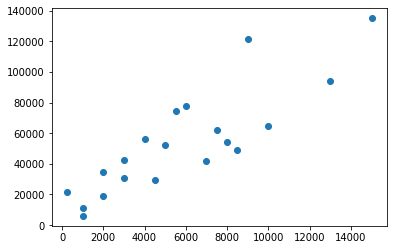

In [22]:
plt.plot(populations,converge_times,'o')

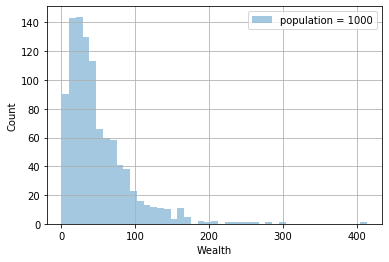

In [38]:

anim = meta_sim.animate_population_dists()
HTML(anim.to_jshtml())

final time:  400.0
at t: 0
at t: 10
at t: 20
at t: 30
at t: 40
at t: 50
at t: 60
at t: 70
at t: 80
at t: 90
at t: 100
at t: 110
at t: 120
at t: 130
at t: 140
at t: 150
at t: 160
at t: 170
at t: 180
at t: 190
at t: 200
at t: 210
at t: 220
at t: 230
at t: 240
at t: 250
at t: 260
at t: 270
at t: 280
at t: 290
at t: 300
at t: 310
at t: 320
at t: 330
at t: 340
at t: 350
at t: 360
at t: 370
at t: 380
at t: 390
at t: 400
finished
Population: 10


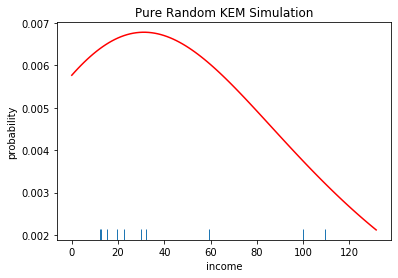

final time:  4000.0
at t: 0
at t: 100
at t: 200
at t: 300
at t: 400
at t: 500
at t: 600
at t: 700
at t: 800
at t: 900
at t: 1000
at t: 1100
at t: 1200
at t: 1300
at t: 1400
at t: 1500
at t: 1600
at t: 1700
at t: 1800
at t: 1900
at t: 2000
at t: 2100
at t: 2200
at t: 2300
at t: 2400
at t: 2500
at t: 2600
at t: 2700
at t: 2800
at t: 2900
at t: 3000
at t: 3100
at t: 3200
at t: 3300
at t: 3400
at t: 3500
at t: 3600
at t: 3700
at t: 3800
at t: 3900
at t: 4000
finished
Population: 100


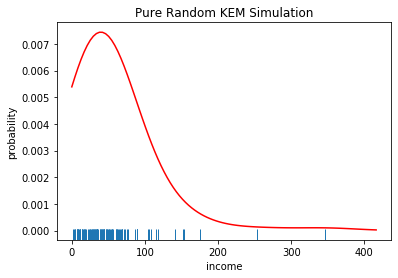

final time:  40000.0
at t: 0
at t: 1000
at t: 2000
at t: 3000
at t: 4000
at t: 5000
at t: 6000
at t: 7000
at t: 8000
at t: 9000
at t: 10000
at t: 11000
at t: 12000
at t: 13000
at t: 14000
at t: 15000
at t: 16000
at t: 17000
at t: 18000
at t: 19000
at t: 20000
at t: 21000
at t: 22000
at t: 23000
at t: 24000
at t: 25000
at t: 26000
at t: 27000
at t: 28000
at t: 29000
at t: 30000
at t: 31000
at t: 32000
at t: 33000
at t: 34000
at t: 35000
at t: 36000
at t: 37000
at t: 38000
at t: 39000
at t: 40000
finished
Population: 1000


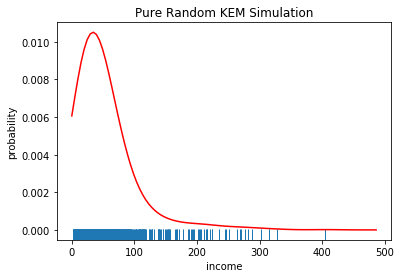

final time:  400000.0
at t: 0
at t: 10000
at t: 20000
at t: 30000
at t: 40000
at t: 50000
at t: 60000
at t: 70000
at t: 80000
at t: 90000
at t: 100000
at t: 110000
at t: 120000
at t: 130000
at t: 140000
at t: 150000
at t: 160000
at t: 170000
at t: 180000
at t: 190000
at t: 200000
at t: 210000
at t: 220000
at t: 230000
at t: 240000
at t: 250000
at t: 260000
at t: 270000
at t: 280000
at t: 290000
at t: 300000
at t: 310000
at t: 320000
at t: 330000
at t: 340000
at t: 350000
at t: 360000
at t: 370000
at t: 380000
at t: 390000
at t: 400000
finished
Population: 10000


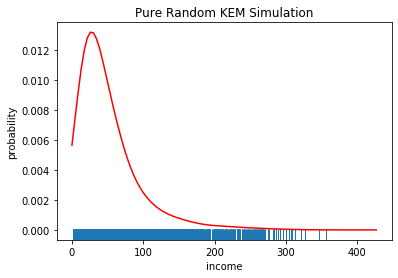

final time:  4000000.0
at t: 0


KeyboardInterrupt: 

In [38]:
pops = [10,100,1000,10000,100000]
for pop in pops:
    sim = Pure_Random(N=pop,mu=50.)
    sim.run(convergence="manual")
    print("Population:",sim.N)
    sim.kde_dist()

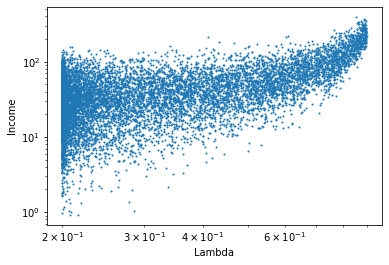